In [1]:
!pip install pillow tqdm

In [2]:
import os
import urllib.request
import zipfile

os.makedirs("div2k", exist_ok=True)

url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"
zip_path = "div2k/DIV2K_valid_HR.zip"

if not os.path.exists(zip_path):
    print("Downloading DIV2K HR...")
    urllib.request.urlretrieve(url, zip_path)

print("Extracting...")
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("div2k")

Extracting...


In [3]:
from PIL import Image
import numpy as np
import glob

image_paths = sorted(glob.glob("div2k/DIV2K_valid_HR/*.png"))[:100]

X, Y = [], []

for path in image_paths:
    img = Image.open(path).convert("RGB").resize((128, 128))

    rgb = np.array(img) / 255.0

    gray = np.array(img.convert("L")) / 255.0
    gray = np.expand_dims(gray, axis=-1)  # shape: (128,128,1)

    X.append(gray)
    Y.append(rgb)

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

print("Dataset shapes:", X.shape, Y.shape)

Dataset shapes: (100, 128, 128, 1) (100, 128, 128, 3)


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class ColorizationDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X).permute(0,3,1,2)  # (N,1,128,128)
        self.Y = torch.tensor(Y).permute(0,3,1,2)  # (N,3,128,128)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = ColorizationDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [5]:
import torch.nn as nn
# ----------------- NEW CNN RESIDUAL ENCODER–DECODER ---------------------
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch, ch, 3, padding=1)
        )
    def forward(self, x):
        return x + self.block(x)     # residual skip


class GrayToColorNet(nn.Module):
    def __init__(self, H=128, W=128):
        super().__init__()
        self.H, self.W = H, W

        # ---------- Encoder ----------
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),   # 1→32
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 128→64
            nn.ReLU(inplace=True),

            ResBlock(64),    # RESIDUAL #1
            ResBlock(64),    # RESIDUAL #2
        )

        # ---------- Decoder ----------
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 64→128
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 3, 3, padding=1),  # final RGB map
        )

    def forward(self, x):
        # Encoder
        z = self.enc(x)

        # Decoder
        out = self.dec(z)

        # Simple residual from gray → replicate to 3 channels
        gray_res = x.repeat(1, 3, 1, 1)
        out = out + gray_res

        # clamp to valid range
        out = torch.clamp(out, 0.0, 1.0)
        return out

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = GrayToColorNet().to(device)

Using device: cuda


In [7]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000

for epoch in range(epochs):
    loop = tqdm(loader)
    total_loss = 0

    for gray, rgb in loop:
        gray, rgb = gray.cuda(), rgb.cuda()

        optimizer.zero_grad()
        out = model(gray)
        loss = criterion(out, rgb)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Average Loss: {total_loss/len(loader):.4f}")

Epoch 1: 100%|██████████| 25/25 [00:01<00:00, 13.89it/s, loss=0.00884]


Epoch 1 Average Loss: 0.0088


Epoch 2: 100%|██████████| 25/25 [00:00<00:00, 80.96it/s, loss=0.00842]


Epoch 2 Average Loss: 0.0086


Epoch 3: 100%|██████████| 25/25 [00:00<00:00, 80.68it/s, loss=0.0116]


Epoch 3 Average Loss: 0.0086


Epoch 4: 100%|██████████| 25/25 [00:00<00:00, 84.18it/s, loss=0.0055]


Epoch 4 Average Loss: 0.0086


Epoch 5: 100%|██████████| 25/25 [00:00<00:00, 87.85it/s, loss=0.00678]


Epoch 5 Average Loss: 0.0086


Epoch 6: 100%|██████████| 25/25 [00:00<00:00, 87.22it/s, loss=0.0116]


Epoch 6 Average Loss: 0.0086


Epoch 7: 100%|██████████| 25/25 [00:00<00:00, 86.87it/s, loss=0.0115]


Epoch 7 Average Loss: 0.0086


Epoch 8: 100%|██████████| 25/25 [00:00<00:00, 87.52it/s, loss=0.00605]


Epoch 8 Average Loss: 0.0086


Epoch 9: 100%|██████████| 25/25 [00:00<00:00, 86.42it/s, loss=0.0158]


Epoch 9 Average Loss: 0.0086


Epoch 10: 100%|██████████| 25/25 [00:00<00:00, 86.30it/s, loss=0.0082]


Epoch 10 Average Loss: 0.0086


Epoch 11: 100%|██████████| 25/25 [00:00<00:00, 87.60it/s, loss=0.00633]


Epoch 11 Average Loss: 0.0086


Epoch 12: 100%|██████████| 25/25 [00:00<00:00, 86.91it/s, loss=0.00933]


Epoch 12 Average Loss: 0.0086


Epoch 13: 100%|██████████| 25/25 [00:00<00:00, 85.10it/s, loss=0.00489]


Epoch 13 Average Loss: 0.0086


Epoch 14: 100%|██████████| 25/25 [00:00<00:00, 87.13it/s, loss=0.00451]


Epoch 14 Average Loss: 0.0086


Epoch 15: 100%|██████████| 25/25 [00:00<00:00, 86.98it/s, loss=0.00943]


Epoch 15 Average Loss: 0.0086


Epoch 16: 100%|██████████| 25/25 [00:00<00:00, 86.98it/s, loss=0.00325]


Epoch 16 Average Loss: 0.0086


Epoch 17: 100%|██████████| 25/25 [00:00<00:00, 86.78it/s, loss=0.0193]


Epoch 17 Average Loss: 0.0086


Epoch 18: 100%|██████████| 25/25 [00:00<00:00, 86.08it/s, loss=0.00625]


Epoch 18 Average Loss: 0.0086


Epoch 19: 100%|██████████| 25/25 [00:00<00:00, 84.74it/s, loss=0.0125]


Epoch 19 Average Loss: 0.0086


Epoch 20: 100%|██████████| 25/25 [00:00<00:00, 87.10it/s, loss=0.00481]


Epoch 20 Average Loss: 0.0086


Epoch 21: 100%|██████████| 25/25 [00:00<00:00, 86.05it/s, loss=0.00441]


Epoch 21 Average Loss: 0.0086


Epoch 22: 100%|██████████| 25/25 [00:00<00:00, 86.30it/s, loss=0.00362]


Epoch 22 Average Loss: 0.0086


Epoch 23: 100%|██████████| 25/25 [00:00<00:00, 86.15it/s, loss=0.00596]


Epoch 23 Average Loss: 0.0085


Epoch 24: 100%|██████████| 25/25 [00:00<00:00, 86.61it/s, loss=0.0128]


Epoch 24 Average Loss: 0.0086


Epoch 25: 100%|██████████| 25/25 [00:00<00:00, 86.34it/s, loss=0.0125]


Epoch 25 Average Loss: 0.0086


Epoch 26: 100%|██████████| 25/25 [00:00<00:00, 85.25it/s, loss=0.0161]


Epoch 26 Average Loss: 0.0085


Epoch 27: 100%|██████████| 25/25 [00:00<00:00, 87.25it/s, loss=0.0061]


Epoch 27 Average Loss: 0.0085


Epoch 28: 100%|██████████| 25/25 [00:00<00:00, 88.58it/s, loss=0.00566]


Epoch 28 Average Loss: 0.0086


Epoch 29: 100%|██████████| 25/25 [00:00<00:00, 86.53it/s, loss=0.0064]


Epoch 29 Average Loss: 0.0085


Epoch 30: 100%|██████████| 25/25 [00:00<00:00, 86.44it/s, loss=0.0168]


Epoch 30 Average Loss: 0.0085


Epoch 31: 100%|██████████| 25/25 [00:00<00:00, 86.57it/s, loss=0.0125]


Epoch 31 Average Loss: 0.0085


Epoch 32: 100%|██████████| 25/25 [00:00<00:00, 87.35it/s, loss=0.00689]


Epoch 32 Average Loss: 0.0085


Epoch 33: 100%|██████████| 25/25 [00:00<00:00, 85.52it/s, loss=0.00418]


Epoch 33 Average Loss: 0.0083


Epoch 34: 100%|██████████| 25/25 [00:00<00:00, 85.45it/s, loss=0.00417]


Epoch 34 Average Loss: 0.0083


Epoch 35: 100%|██████████| 25/25 [00:00<00:00, 85.94it/s, loss=0.00456]


Epoch 35 Average Loss: 0.0085


Epoch 36: 100%|██████████| 25/25 [00:00<00:00, 85.73it/s, loss=0.00562]


Epoch 36 Average Loss: 0.0084


Epoch 37: 100%|██████████| 25/25 [00:00<00:00, 85.13it/s, loss=0.0061]


Epoch 37 Average Loss: 0.0082


Epoch 38: 100%|██████████| 25/25 [00:00<00:00, 84.11it/s, loss=0.00706]


Epoch 38 Average Loss: 0.0082


Epoch 39: 100%|██████████| 25/25 [00:00<00:00, 82.67it/s, loss=0.00814]


Epoch 39 Average Loss: 0.0078


Epoch 40: 100%|██████████| 25/25 [00:00<00:00, 87.59it/s, loss=0.00531]


Epoch 40 Average Loss: 0.0076


Epoch 41: 100%|██████████| 25/25 [00:00<00:00, 88.43it/s, loss=0.00355]


Epoch 41 Average Loss: 0.0082


Epoch 42: 100%|██████████| 25/25 [00:00<00:00, 83.70it/s, loss=0.00481]


Epoch 42 Average Loss: 0.0079


Epoch 43: 100%|██████████| 25/25 [00:00<00:00, 85.77it/s, loss=0.011]


Epoch 43 Average Loss: 0.0081


Epoch 44: 100%|██████████| 25/25 [00:00<00:00, 85.78it/s, loss=0.00569]


Epoch 44 Average Loss: 0.0081


Epoch 45: 100%|██████████| 25/25 [00:00<00:00, 86.62it/s, loss=0.00599]


Epoch 45 Average Loss: 0.0076


Epoch 46: 100%|██████████| 25/25 [00:00<00:00, 81.97it/s, loss=0.0115]


Epoch 46 Average Loss: 0.0075


Epoch 47: 100%|██████████| 25/25 [00:00<00:00, 85.82it/s, loss=0.00542]


Epoch 47 Average Loss: 0.0080


Epoch 48: 100%|██████████| 25/25 [00:00<00:00, 86.15it/s, loss=0.00491]


Epoch 48 Average Loss: 0.0078


Epoch 49: 100%|██████████| 25/25 [00:00<00:00, 87.34it/s, loss=0.00757]


Epoch 49 Average Loss: 0.0077


Epoch 50: 100%|██████████| 25/25 [00:00<00:00, 87.75it/s, loss=0.00783]


Epoch 50 Average Loss: 0.0075


Epoch 51: 100%|██████████| 25/25 [00:00<00:00, 84.22it/s, loss=0.00698]


Epoch 51 Average Loss: 0.0077


Epoch 52: 100%|██████████| 25/25 [00:00<00:00, 86.65it/s, loss=0.00194]


Epoch 52 Average Loss: 0.0073


Epoch 53: 100%|██████████| 25/25 [00:00<00:00, 85.48it/s, loss=0.00942]


Epoch 53 Average Loss: 0.0077


Epoch 54: 100%|██████████| 25/25 [00:00<00:00, 85.33it/s, loss=0.0034]


Epoch 54 Average Loss: 0.0076


Epoch 55: 100%|██████████| 25/25 [00:00<00:00, 84.65it/s, loss=0.00291]


Epoch 55 Average Loss: 0.0074


Epoch 56: 100%|██████████| 25/25 [00:00<00:00, 87.32it/s, loss=0.00659]


Epoch 56 Average Loss: 0.0072


Epoch 57: 100%|██████████| 25/25 [00:00<00:00, 87.40it/s, loss=0.00881]


Epoch 57 Average Loss: 0.0070


Epoch 58: 100%|██████████| 25/25 [00:00<00:00, 85.62it/s, loss=0.00524]


Epoch 58 Average Loss: 0.0071


Epoch 59: 100%|██████████| 25/25 [00:00<00:00, 86.03it/s, loss=0.00448]


Epoch 59 Average Loss: 0.0070


Epoch 60: 100%|██████████| 25/25 [00:00<00:00, 86.23it/s, loss=0.008]


Epoch 60 Average Loss: 0.0077


Epoch 61: 100%|██████████| 25/25 [00:00<00:00, 86.19it/s, loss=0.00312]


Epoch 61 Average Loss: 0.0074


Epoch 62: 100%|██████████| 25/25 [00:00<00:00, 85.37it/s, loss=0.00579]


Epoch 62 Average Loss: 0.0070


Epoch 63: 100%|██████████| 25/25 [00:00<00:00, 85.42it/s, loss=0.00678]


Epoch 63 Average Loss: 0.0072


Epoch 64: 100%|██████████| 25/25 [00:00<00:00, 87.18it/s, loss=0.00719]


Epoch 64 Average Loss: 0.0070


Epoch 65: 100%|██████████| 25/25 [00:00<00:00, 85.74it/s, loss=0.00443]


Epoch 65 Average Loss: 0.0071


Epoch 66: 100%|██████████| 25/25 [00:00<00:00, 87.06it/s, loss=0.00482]


Epoch 66 Average Loss: 0.0070


Epoch 67: 100%|██████████| 25/25 [00:00<00:00, 85.04it/s, loss=0.00457]


Epoch 67 Average Loss: 0.0071


Epoch 68: 100%|██████████| 25/25 [00:00<00:00, 85.58it/s, loss=0.00796]


Epoch 68 Average Loss: 0.0071


Epoch 69: 100%|██████████| 25/25 [00:00<00:00, 84.74it/s, loss=0.00259]


Epoch 69 Average Loss: 0.0077


Epoch 70: 100%|██████████| 25/25 [00:00<00:00, 84.41it/s, loss=0.00428]


Epoch 70 Average Loss: 0.0072


Epoch 71: 100%|██████████| 25/25 [00:00<00:00, 85.71it/s, loss=0.00507]


Epoch 71 Average Loss: 0.0071


Epoch 72: 100%|██████████| 25/25 [00:00<00:00, 84.53it/s, loss=0.00399]


Epoch 72 Average Loss: 0.0069


Epoch 73: 100%|██████████| 25/25 [00:00<00:00, 84.92it/s, loss=0.0109]


Epoch 73 Average Loss: 0.0069


Epoch 74: 100%|██████████| 25/25 [00:00<00:00, 85.28it/s, loss=0.00467]


Epoch 74 Average Loss: 0.0069


Epoch 75: 100%|██████████| 25/25 [00:00<00:00, 86.13it/s, loss=0.0108]


Epoch 75 Average Loss: 0.0069


Epoch 76: 100%|██████████| 25/25 [00:00<00:00, 84.52it/s, loss=0.0116]


Epoch 76 Average Loss: 0.0069


Epoch 77: 100%|██████████| 25/25 [00:00<00:00, 85.18it/s, loss=0.00392]


Epoch 77 Average Loss: 0.0069


Epoch 78: 100%|██████████| 25/25 [00:00<00:00, 85.26it/s, loss=0.0071]


Epoch 78 Average Loss: 0.0070


Epoch 79: 100%|██████████| 25/25 [00:00<00:00, 85.05it/s, loss=0.00231]


Epoch 79 Average Loss: 0.0070


Epoch 80: 100%|██████████| 25/25 [00:00<00:00, 85.68it/s, loss=0.00568]


Epoch 80 Average Loss: 0.0068


Epoch 81: 100%|██████████| 25/25 [00:00<00:00, 83.84it/s, loss=0.0108]


Epoch 81 Average Loss: 0.0069


Epoch 82: 100%|██████████| 25/25 [00:00<00:00, 80.71it/s, loss=0.00498]


Epoch 82 Average Loss: 0.0071


Epoch 83: 100%|██████████| 25/25 [00:00<00:00, 81.39it/s, loss=0.00331]


Epoch 83 Average Loss: 0.0071


Epoch 84: 100%|██████████| 25/25 [00:00<00:00, 86.75it/s, loss=0.0058]


Epoch 84 Average Loss: 0.0070


Epoch 85: 100%|██████████| 25/25 [00:00<00:00, 87.43it/s, loss=0.0032]


Epoch 85 Average Loss: 0.0071


Epoch 86: 100%|██████████| 25/25 [00:00<00:00, 87.04it/s, loss=0.00307]


Epoch 86 Average Loss: 0.0069


Epoch 87: 100%|██████████| 25/25 [00:00<00:00, 85.92it/s, loss=0.0043]


Epoch 87 Average Loss: 0.0068


Epoch 88: 100%|██████████| 25/25 [00:00<00:00, 87.82it/s, loss=0.00612]


Epoch 88 Average Loss: 0.0071


Epoch 89: 100%|██████████| 25/25 [00:00<00:00, 84.24it/s, loss=0.00468]


Epoch 89 Average Loss: 0.0068


Epoch 90: 100%|██████████| 25/25 [00:00<00:00, 81.56it/s, loss=0.00975]


Epoch 90 Average Loss: 0.0070


Epoch 91: 100%|██████████| 25/25 [00:00<00:00, 82.50it/s, loss=0.00487]


Epoch 91 Average Loss: 0.0068


Epoch 92: 100%|██████████| 25/25 [00:00<00:00, 81.94it/s, loss=0.0056]


Epoch 92 Average Loss: 0.0068


Epoch 93: 100%|██████████| 25/25 [00:00<00:00, 85.90it/s, loss=0.00498]


Epoch 93 Average Loss: 0.0068


Epoch 94: 100%|██████████| 25/25 [00:00<00:00, 85.15it/s, loss=0.00934]


Epoch 94 Average Loss: 0.0067


Epoch 95: 100%|██████████| 25/25 [00:00<00:00, 83.91it/s, loss=0.00893]


Epoch 95 Average Loss: 0.0068


Epoch 96: 100%|██████████| 25/25 [00:00<00:00, 85.09it/s, loss=0.0109]


Epoch 96 Average Loss: 0.0068


Epoch 97: 100%|██████████| 25/25 [00:00<00:00, 84.32it/s, loss=0.012]


Epoch 97 Average Loss: 0.0067


Epoch 98: 100%|██████████| 25/25 [00:00<00:00, 83.89it/s, loss=0.00501]


Epoch 98 Average Loss: 0.0068


Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 84.29it/s, loss=0.00616]


Epoch 99 Average Loss: 0.0068


Epoch 100: 100%|██████████| 25/25 [00:00<00:00, 84.95it/s, loss=0.00364]


Epoch 100 Average Loss: 0.0068


Epoch 101: 100%|██████████| 25/25 [00:00<00:00, 84.88it/s, loss=0.00217]


Epoch 101 Average Loss: 0.0066


Epoch 102: 100%|██████████| 25/25 [00:00<00:00, 83.96it/s, loss=0.00673]


Epoch 102 Average Loss: 0.0068


Epoch 103: 100%|██████████| 25/25 [00:00<00:00, 85.60it/s, loss=0.00771]


Epoch 103 Average Loss: 0.0067


Epoch 104: 100%|██████████| 25/25 [00:00<00:00, 82.36it/s, loss=0.00366]


Epoch 104 Average Loss: 0.0066


Epoch 105: 100%|██████████| 25/25 [00:00<00:00, 84.52it/s, loss=0.00681]


Epoch 105 Average Loss: 0.0067


Epoch 106: 100%|██████████| 25/25 [00:00<00:00, 84.18it/s, loss=0.0061]


Epoch 106 Average Loss: 0.0067


Epoch 107: 100%|██████████| 25/25 [00:00<00:00, 85.16it/s, loss=0.00416]


Epoch 107 Average Loss: 0.0067


Epoch 108: 100%|██████████| 25/25 [00:00<00:00, 85.66it/s, loss=0.0118]


Epoch 108 Average Loss: 0.0066


Epoch 109: 100%|██████████| 25/25 [00:00<00:00, 84.21it/s, loss=0.00356]


Epoch 109 Average Loss: 0.0065


Epoch 110: 100%|██████████| 25/25 [00:00<00:00, 85.23it/s, loss=0.0124]


Epoch 110 Average Loss: 0.0065


Epoch 111: 100%|██████████| 25/25 [00:00<00:00, 84.40it/s, loss=0.0101]


Epoch 111 Average Loss: 0.0064


Epoch 112: 100%|██████████| 25/25 [00:00<00:00, 84.47it/s, loss=0.00307]


Epoch 112 Average Loss: 0.0070


Epoch 113: 100%|██████████| 25/25 [00:00<00:00, 63.30it/s, loss=0.00353]


Epoch 113 Average Loss: 0.0066


Epoch 114: 100%|██████████| 25/25 [00:00<00:00, 64.50it/s, loss=0.00842]


Epoch 114 Average Loss: 0.0071


Epoch 115: 100%|██████████| 25/25 [00:00<00:00, 79.85it/s, loss=0.0122]


Epoch 115 Average Loss: 0.0066


Epoch 116: 100%|██████████| 25/25 [00:00<00:00, 55.09it/s, loss=0.00655]


Epoch 116 Average Loss: 0.0067


Epoch 117: 100%|██████████| 25/25 [00:00<00:00, 85.12it/s, loss=0.00785]


Epoch 117 Average Loss: 0.0066


Epoch 118: 100%|██████████| 25/25 [00:00<00:00, 56.13it/s, loss=0.00998]


Epoch 118 Average Loss: 0.0065


Epoch 119: 100%|██████████| 25/25 [00:00<00:00, 73.68it/s, loss=0.00741]


Epoch 119 Average Loss: 0.0065


Epoch 120: 100%|██████████| 25/25 [00:00<00:00, 80.89it/s, loss=0.0142]


Epoch 120 Average Loss: 0.0065


Epoch 121: 100%|██████████| 25/25 [00:00<00:00, 83.56it/s, loss=0.00791]


Epoch 121 Average Loss: 0.0065


Epoch 122: 100%|██████████| 25/25 [00:00<00:00, 85.44it/s, loss=0.0108]


Epoch 122 Average Loss: 0.0064


Epoch 123: 100%|██████████| 25/25 [00:00<00:00, 83.61it/s, loss=0.00381]


Epoch 123 Average Loss: 0.0066


Epoch 124: 100%|██████████| 25/25 [00:00<00:00, 82.01it/s, loss=0.00758]


Epoch 124 Average Loss: 0.0068


Epoch 125: 100%|██████████| 25/25 [00:00<00:00, 85.61it/s, loss=0.00655]


Epoch 125 Average Loss: 0.0083


Epoch 126: 100%|██████████| 25/25 [00:00<00:00, 86.44it/s, loss=0.0155]


Epoch 126 Average Loss: 0.0076


Epoch 127: 100%|██████████| 25/25 [00:00<00:00, 84.51it/s, loss=0.00545]


Epoch 127 Average Loss: 0.0067


Epoch 128: 100%|██████████| 25/25 [00:00<00:00, 86.47it/s, loss=0.00522]


Epoch 128 Average Loss: 0.0064


Epoch 129: 100%|██████████| 25/25 [00:00<00:00, 87.50it/s, loss=0.00195]


Epoch 129 Average Loss: 0.0065


Epoch 130: 100%|██████████| 25/25 [00:00<00:00, 86.34it/s, loss=0.00675]


Epoch 130 Average Loss: 0.0064


Epoch 131: 100%|██████████| 25/25 [00:00<00:00, 84.36it/s, loss=0.00495]


Epoch 131 Average Loss: 0.0064


Epoch 132: 100%|██████████| 25/25 [00:00<00:00, 85.39it/s, loss=0.00869]


Epoch 132 Average Loss: 0.0065


Epoch 133: 100%|██████████| 25/25 [00:00<00:00, 81.23it/s, loss=0.00556]


Epoch 133 Average Loss: 0.0065


Epoch 134: 100%|██████████| 25/25 [00:00<00:00, 78.15it/s, loss=0.0096]


Epoch 134 Average Loss: 0.0065


Epoch 135: 100%|██████████| 25/25 [00:00<00:00, 75.83it/s, loss=0.00936]


Epoch 135 Average Loss: 0.0066


Epoch 136: 100%|██████████| 25/25 [00:00<00:00, 83.86it/s, loss=0.0103]


Epoch 136 Average Loss: 0.0064


Epoch 137: 100%|██████████| 25/25 [00:00<00:00, 83.45it/s, loss=0.00857]


Epoch 137 Average Loss: 0.0065


Epoch 138: 100%|██████████| 25/25 [00:00<00:00, 84.03it/s, loss=0.00631]


Epoch 138 Average Loss: 0.0066


Epoch 139: 100%|██████████| 25/25 [00:00<00:00, 83.91it/s, loss=0.00578]


Epoch 139 Average Loss: 0.0068


Epoch 140: 100%|██████████| 25/25 [00:00<00:00, 82.56it/s, loss=0.00454]


Epoch 140 Average Loss: 0.0065


Epoch 141: 100%|██████████| 25/25 [00:00<00:00, 82.74it/s, loss=0.00162]


Epoch 141 Average Loss: 0.0064


Epoch 142: 100%|██████████| 25/25 [00:00<00:00, 81.65it/s, loss=0.00914]


Epoch 142 Average Loss: 0.0063


Epoch 143: 100%|██████████| 25/25 [00:00<00:00, 79.83it/s, loss=0.0105]


Epoch 143 Average Loss: 0.0064


Epoch 144: 100%|██████████| 25/25 [00:00<00:00, 83.57it/s, loss=0.0044]


Epoch 144 Average Loss: 0.0066


Epoch 145: 100%|██████████| 25/25 [00:00<00:00, 85.36it/s, loss=0.00408]


Epoch 145 Average Loss: 0.0063


Epoch 146: 100%|██████████| 25/25 [00:00<00:00, 84.09it/s, loss=0.00413]


Epoch 146 Average Loss: 0.0064


Epoch 147: 100%|██████████| 25/25 [00:00<00:00, 82.67it/s, loss=0.0112]


Epoch 147 Average Loss: 0.0063


Epoch 148: 100%|██████████| 25/25 [00:00<00:00, 83.71it/s, loss=0.00681]


Epoch 148 Average Loss: 0.0066


Epoch 149: 100%|██████████| 25/25 [00:00<00:00, 84.16it/s, loss=0.00556]


Epoch 149 Average Loss: 0.0063


Epoch 150: 100%|██████████| 25/25 [00:00<00:00, 84.25it/s, loss=0.00645]


Epoch 150 Average Loss: 0.0064


Epoch 151: 100%|██████████| 25/25 [00:00<00:00, 83.76it/s, loss=0.0138]


Epoch 151 Average Loss: 0.0064


Epoch 152: 100%|██████████| 25/25 [00:00<00:00, 84.15it/s, loss=0.00341]


Epoch 152 Average Loss: 0.0063


Epoch 153: 100%|██████████| 25/25 [00:00<00:00, 82.95it/s, loss=0.0068]


Epoch 153 Average Loss: 0.0063


Epoch 154: 100%|██████████| 25/25 [00:00<00:00, 83.84it/s, loss=0.00581]


Epoch 154 Average Loss: 0.0062


Epoch 155: 100%|██████████| 25/25 [00:00<00:00, 82.92it/s, loss=0.00432]


Epoch 155 Average Loss: 0.0063


Epoch 156: 100%|██████████| 25/25 [00:00<00:00, 83.47it/s, loss=0.00638]


Epoch 156 Average Loss: 0.0062


Epoch 157: 100%|██████████| 25/25 [00:00<00:00, 84.79it/s, loss=0.00951]


Epoch 157 Average Loss: 0.0062


Epoch 158: 100%|██████████| 25/25 [00:00<00:00, 82.82it/s, loss=0.0115]


Epoch 158 Average Loss: 0.0062


Epoch 159: 100%|██████████| 25/25 [00:00<00:00, 83.41it/s, loss=0.00463]


Epoch 159 Average Loss: 0.0062


Epoch 160: 100%|██████████| 25/25 [00:00<00:00, 83.13it/s, loss=0.00419]


Epoch 160 Average Loss: 0.0064


Epoch 161: 100%|██████████| 25/25 [00:00<00:00, 83.31it/s, loss=0.00476]


Epoch 161 Average Loss: 0.0062


Epoch 162: 100%|██████████| 25/25 [00:00<00:00, 82.65it/s, loss=0.00284]


Epoch 162 Average Loss: 0.0062


Epoch 163: 100%|██████████| 25/25 [00:00<00:00, 83.21it/s, loss=0.00484]


Epoch 163 Average Loss: 0.0061


Epoch 164: 100%|██████████| 25/25 [00:00<00:00, 84.43it/s, loss=0.0114]


Epoch 164 Average Loss: 0.0062


Epoch 165: 100%|██████████| 25/25 [00:00<00:00, 84.02it/s, loss=0.00773]


Epoch 165 Average Loss: 0.0062


Epoch 166: 100%|██████████| 25/25 [00:00<00:00, 83.78it/s, loss=0.00671]


Epoch 166 Average Loss: 0.0062


Epoch 167: 100%|██████████| 25/25 [00:00<00:00, 84.62it/s, loss=0.00487]


Epoch 167 Average Loss: 0.0062


Epoch 168: 100%|██████████| 25/25 [00:00<00:00, 82.99it/s, loss=0.00488]


Epoch 168 Average Loss: 0.0060


Epoch 169: 100%|██████████| 25/25 [00:00<00:00, 79.71it/s, loss=0.00386]


Epoch 169 Average Loss: 0.0061


Epoch 170: 100%|██████████| 25/25 [00:00<00:00, 79.93it/s, loss=0.00408]


Epoch 170 Average Loss: 0.0060


Epoch 171: 100%|██████████| 25/25 [00:00<00:00, 85.15it/s, loss=0.0103]


Epoch 171 Average Loss: 0.0061


Epoch 172: 100%|██████████| 25/25 [00:00<00:00, 85.15it/s, loss=0.0105]


Epoch 172 Average Loss: 0.0061


Epoch 173: 100%|██████████| 25/25 [00:00<00:00, 78.06it/s, loss=0.00481]


Epoch 173 Average Loss: 0.0062


Epoch 174: 100%|██████████| 25/25 [00:00<00:00, 82.89it/s, loss=0.00189]


Epoch 174 Average Loss: 0.0062


Epoch 175: 100%|██████████| 25/25 [00:00<00:00, 86.74it/s, loss=0.00981]


Epoch 175 Average Loss: 0.0062


Epoch 176: 100%|██████████| 25/25 [00:00<00:00, 83.80it/s, loss=0.0132]


Epoch 176 Average Loss: 0.0062


Epoch 177: 100%|██████████| 25/25 [00:00<00:00, 81.08it/s, loss=0.00292]


Epoch 177 Average Loss: 0.0059


Epoch 178: 100%|██████████| 25/25 [00:00<00:00, 84.39it/s, loss=0.00309]


Epoch 178 Average Loss: 0.0061


Epoch 179: 100%|██████████| 25/25 [00:00<00:00, 82.26it/s, loss=0.00771]


Epoch 179 Average Loss: 0.0059


Epoch 180: 100%|██████████| 25/25 [00:00<00:00, 81.82it/s, loss=0.00294]


Epoch 180 Average Loss: 0.0059


Epoch 181: 100%|██████████| 25/25 [00:00<00:00, 86.29it/s, loss=0.00457]


Epoch 181 Average Loss: 0.0058


Epoch 182: 100%|██████████| 25/25 [00:00<00:00, 80.82it/s, loss=0.00271]


Epoch 182 Average Loss: 0.0061


Epoch 183: 100%|██████████| 25/25 [00:00<00:00, 81.40it/s, loss=0.00738]


Epoch 183 Average Loss: 0.0060


Epoch 184: 100%|██████████| 25/25 [00:00<00:00, 83.44it/s, loss=0.00844]


Epoch 184 Average Loss: 0.0059


Epoch 185: 100%|██████████| 25/25 [00:00<00:00, 83.20it/s, loss=0.00945]


Epoch 185 Average Loss: 0.0059


Epoch 186: 100%|██████████| 25/25 [00:00<00:00, 82.86it/s, loss=0.00357]


Epoch 186 Average Loss: 0.0058


Epoch 187: 100%|██████████| 25/25 [00:00<00:00, 83.91it/s, loss=0.00652]


Epoch 187 Average Loss: 0.0057


Epoch 188: 100%|██████████| 25/25 [00:00<00:00, 83.82it/s, loss=0.00555]


Epoch 188 Average Loss: 0.0059


Epoch 189: 100%|██████████| 25/25 [00:00<00:00, 82.63it/s, loss=0.0029]


Epoch 189 Average Loss: 0.0057


Epoch 190: 100%|██████████| 25/25 [00:00<00:00, 82.48it/s, loss=0.00733]


Epoch 190 Average Loss: 0.0058


Epoch 191: 100%|██████████| 25/25 [00:00<00:00, 82.50it/s, loss=0.00394]


Epoch 191 Average Loss: 0.0057


Epoch 192: 100%|██████████| 25/25 [00:00<00:00, 82.81it/s, loss=0.00511]


Epoch 192 Average Loss: 0.0057


Epoch 193: 100%|██████████| 25/25 [00:00<00:00, 79.85it/s, loss=0.00328]


Epoch 193 Average Loss: 0.0058


Epoch 194: 100%|██████████| 25/25 [00:00<00:00, 83.62it/s, loss=0.0054]


Epoch 194 Average Loss: 0.0058


Epoch 195: 100%|██████████| 25/25 [00:00<00:00, 82.84it/s, loss=0.00744]


Epoch 195 Average Loss: 0.0059


Epoch 196: 100%|██████████| 25/25 [00:00<00:00, 84.41it/s, loss=0.00497]


Epoch 196 Average Loss: 0.0056


Epoch 197: 100%|██████████| 25/25 [00:00<00:00, 83.21it/s, loss=0.00685]


Epoch 197 Average Loss: 0.0056


Epoch 198: 100%|██████████| 25/25 [00:00<00:00, 83.61it/s, loss=0.0105]


Epoch 198 Average Loss: 0.0056


Epoch 199: 100%|██████████| 25/25 [00:00<00:00, 83.45it/s, loss=0.00899]


Epoch 199 Average Loss: 0.0056


Epoch 200: 100%|██████████| 25/25 [00:00<00:00, 82.34it/s, loss=0.00465]


Epoch 200 Average Loss: 0.0056


Epoch 201: 100%|██████████| 25/25 [00:00<00:00, 83.63it/s, loss=0.00804]


Epoch 201 Average Loss: 0.0056


Epoch 202: 100%|██████████| 25/25 [00:00<00:00, 84.29it/s, loss=0.00846]


Epoch 202 Average Loss: 0.0055


Epoch 203: 100%|██████████| 25/25 [00:00<00:00, 82.91it/s, loss=0.00353]


Epoch 203 Average Loss: 0.0057


Epoch 204: 100%|██████████| 25/25 [00:00<00:00, 80.90it/s, loss=0.00772]


Epoch 204 Average Loss: 0.0058


Epoch 205: 100%|██████████| 25/25 [00:00<00:00, 82.79it/s, loss=0.00506]


Epoch 205 Average Loss: 0.0057


Epoch 206: 100%|██████████| 25/25 [00:00<00:00, 84.25it/s, loss=0.00376]


Epoch 206 Average Loss: 0.0057


Epoch 207: 100%|██████████| 25/25 [00:00<00:00, 81.94it/s, loss=0.00415]


Epoch 207 Average Loss: 0.0056


Epoch 208: 100%|██████████| 25/25 [00:00<00:00, 81.92it/s, loss=0.00459]


Epoch 208 Average Loss: 0.0056


Epoch 209: 100%|██████████| 25/25 [00:00<00:00, 81.06it/s, loss=0.00397]


Epoch 209 Average Loss: 0.0055


Epoch 210: 100%|██████████| 25/25 [00:00<00:00, 82.76it/s, loss=0.00548]


Epoch 210 Average Loss: 0.0055


Epoch 211: 100%|██████████| 25/25 [00:00<00:00, 80.18it/s, loss=0.00823]


Epoch 211 Average Loss: 0.0055


Epoch 212: 100%|██████████| 25/25 [00:00<00:00, 82.68it/s, loss=0.00459]


Epoch 212 Average Loss: 0.0055


Epoch 213: 100%|██████████| 25/25 [00:00<00:00, 81.19it/s, loss=0.00273]


Epoch 213 Average Loss: 0.0054


Epoch 214: 100%|██████████| 25/25 [00:00<00:00, 81.06it/s, loss=0.00963]


Epoch 214 Average Loss: 0.0055


Epoch 215: 100%|██████████| 25/25 [00:00<00:00, 79.41it/s, loss=0.0034]


Epoch 215 Average Loss: 0.0054


Epoch 216: 100%|██████████| 25/25 [00:00<00:00, 83.77it/s, loss=0.00538]


Epoch 216 Average Loss: 0.0054


Epoch 217: 100%|██████████| 25/25 [00:00<00:00, 84.37it/s, loss=0.0037]


Epoch 217 Average Loss: 0.0054


Epoch 218: 100%|██████████| 25/25 [00:00<00:00, 85.25it/s, loss=0.00576]


Epoch 218 Average Loss: 0.0053


Epoch 219: 100%|██████████| 25/25 [00:00<00:00, 84.62it/s, loss=0.00899]


Epoch 219 Average Loss: 0.0053


Epoch 220: 100%|██████████| 25/25 [00:00<00:00, 86.17it/s, loss=0.00414]


Epoch 220 Average Loss: 0.0054


Epoch 221: 100%|██████████| 25/25 [00:00<00:00, 85.63it/s, loss=0.00359]


Epoch 221 Average Loss: 0.0053


Epoch 222: 100%|██████████| 25/25 [00:00<00:00, 82.70it/s, loss=0.00594]


Epoch 222 Average Loss: 0.0054


Epoch 223: 100%|██████████| 25/25 [00:00<00:00, 78.08it/s, loss=0.00419]


Epoch 223 Average Loss: 0.0053


Epoch 224: 100%|██████████| 25/25 [00:00<00:00, 78.47it/s, loss=0.00383]


Epoch 224 Average Loss: 0.0052


Epoch 225: 100%|██████████| 25/25 [00:00<00:00, 81.38it/s, loss=0.0097]


Epoch 225 Average Loss: 0.0053


Epoch 226: 100%|██████████| 25/25 [00:00<00:00, 81.92it/s, loss=0.00367]


Epoch 226 Average Loss: 0.0056


Epoch 227: 100%|██████████| 25/25 [00:00<00:00, 79.08it/s, loss=0.00717]


Epoch 227 Average Loss: 0.0057


Epoch 228: 100%|██████████| 25/25 [00:00<00:00, 84.76it/s, loss=0.0065]


Epoch 228 Average Loss: 0.0053


Epoch 229: 100%|██████████| 25/25 [00:00<00:00, 85.31it/s, loss=0.00417]


Epoch 229 Average Loss: 0.0054


Epoch 230: 100%|██████████| 25/25 [00:00<00:00, 83.72it/s, loss=0.0052]


Epoch 230 Average Loss: 0.0053


Epoch 231: 100%|██████████| 25/25 [00:00<00:00, 85.41it/s, loss=0.00523]


Epoch 231 Average Loss: 0.0055


Epoch 232: 100%|██████████| 25/25 [00:00<00:00, 84.34it/s, loss=0.00403]


Epoch 232 Average Loss: 0.0053


Epoch 233: 100%|██████████| 25/25 [00:00<00:00, 85.54it/s, loss=0.00463]


Epoch 233 Average Loss: 0.0052


Epoch 234: 100%|██████████| 25/25 [00:00<00:00, 86.51it/s, loss=0.00273]


Epoch 234 Average Loss: 0.0052


Epoch 235: 100%|██████████| 25/25 [00:00<00:00, 85.94it/s, loss=0.00653]


Epoch 235 Average Loss: 0.0052


Epoch 236: 100%|██████████| 25/25 [00:00<00:00, 81.80it/s, loss=0.00338]


Epoch 236 Average Loss: 0.0052


Epoch 237: 100%|██████████| 25/25 [00:00<00:00, 82.53it/s, loss=0.00316]


Epoch 237 Average Loss: 0.0050


Epoch 238: 100%|██████████| 25/25 [00:00<00:00, 83.77it/s, loss=0.00444]


Epoch 238 Average Loss: 0.0050


Epoch 239: 100%|██████████| 25/25 [00:00<00:00, 81.37it/s, loss=0.00523]


Epoch 239 Average Loss: 0.0052


Epoch 240: 100%|██████████| 25/25 [00:00<00:00, 82.11it/s, loss=0.00373]


Epoch 240 Average Loss: 0.0050


Epoch 241: 100%|██████████| 25/25 [00:00<00:00, 80.72it/s, loss=0.00494]


Epoch 241 Average Loss: 0.0050


Epoch 242: 100%|██████████| 25/25 [00:00<00:00, 81.64it/s, loss=0.00283]


Epoch 242 Average Loss: 0.0049


Epoch 243: 100%|██████████| 25/25 [00:00<00:00, 80.65it/s, loss=0.00269]


Epoch 243 Average Loss: 0.0049


Epoch 244: 100%|██████████| 25/25 [00:00<00:00, 80.51it/s, loss=0.00775]


Epoch 244 Average Loss: 0.0051


Epoch 245: 100%|██████████| 25/25 [00:00<00:00, 82.87it/s, loss=0.00446]


Epoch 245 Average Loss: 0.0050


Epoch 246: 100%|██████████| 25/25 [00:00<00:00, 79.83it/s, loss=0.0102]


Epoch 246 Average Loss: 0.0051


Epoch 247: 100%|██████████| 25/25 [00:00<00:00, 83.78it/s, loss=0.00648]


Epoch 247 Average Loss: 0.0050


Epoch 248: 100%|██████████| 25/25 [00:00<00:00, 80.20it/s, loss=0.0066]


Epoch 248 Average Loss: 0.0051


Epoch 249: 100%|██████████| 25/25 [00:00<00:00, 79.85it/s, loss=0.0054]


Epoch 249 Average Loss: 0.0049


Epoch 250: 100%|██████████| 25/25 [00:00<00:00, 80.98it/s, loss=0.00655]


Epoch 250 Average Loss: 0.0049


Epoch 251: 100%|██████████| 25/25 [00:00<00:00, 82.23it/s, loss=0.00308]


Epoch 251 Average Loss: 0.0048


Epoch 252: 100%|██████████| 25/25 [00:00<00:00, 81.75it/s, loss=0.00495]


Epoch 252 Average Loss: 0.0048


Epoch 253: 100%|██████████| 25/25 [00:00<00:00, 81.98it/s, loss=0.00573]


Epoch 253 Average Loss: 0.0050


Epoch 254: 100%|██████████| 25/25 [00:00<00:00, 81.61it/s, loss=0.009]


Epoch 254 Average Loss: 0.0050


Epoch 255: 100%|██████████| 25/25 [00:00<00:00, 82.22it/s, loss=0.00399]


Epoch 255 Average Loss: 0.0051


Epoch 256: 100%|██████████| 25/25 [00:00<00:00, 82.51it/s, loss=0.000902]


Epoch 256 Average Loss: 0.0048


Epoch 257: 100%|██████████| 25/25 [00:00<00:00, 82.23it/s, loss=0.00583]


Epoch 257 Average Loss: 0.0047


Epoch 258: 100%|██████████| 25/25 [00:00<00:00, 80.87it/s, loss=0.00462]


Epoch 258 Average Loss: 0.0046


Epoch 259: 100%|██████████| 25/25 [00:00<00:00, 81.38it/s, loss=0.00358]


Epoch 259 Average Loss: 0.0046


Epoch 260: 100%|██████████| 25/25 [00:00<00:00, 75.74it/s, loss=0.00235]


Epoch 260 Average Loss: 0.0046


Epoch 261: 100%|██████████| 25/25 [00:00<00:00, 79.28it/s, loss=0.00411]


Epoch 261 Average Loss: 0.0047


Epoch 262: 100%|██████████| 25/25 [00:00<00:00, 82.99it/s, loss=0.00341]


Epoch 262 Average Loss: 0.0046


Epoch 263: 100%|██████████| 25/25 [00:00<00:00, 79.70it/s, loss=0.00406]


Epoch 263 Average Loss: 0.0047


Epoch 264: 100%|██████████| 25/25 [00:00<00:00, 86.20it/s, loss=0.00731]


Epoch 264 Average Loss: 0.0050


Epoch 265: 100%|██████████| 25/25 [00:00<00:00, 85.76it/s, loss=0.0045]


Epoch 265 Average Loss: 0.0048


Epoch 266: 100%|██████████| 25/25 [00:00<00:00, 84.68it/s, loss=0.00443]


Epoch 266 Average Loss: 0.0046


Epoch 267: 100%|██████████| 25/25 [00:00<00:00, 84.37it/s, loss=0.00256]


Epoch 267 Average Loss: 0.0046


Epoch 268: 100%|██████████| 25/25 [00:00<00:00, 84.59it/s, loss=0.00765]


Epoch 268 Average Loss: 0.0045


Epoch 269: 100%|██████████| 25/25 [00:00<00:00, 80.97it/s, loss=0.00444]


Epoch 269 Average Loss: 0.0046


Epoch 270: 100%|██████████| 25/25 [00:00<00:00, 79.97it/s, loss=0.00923]


Epoch 270 Average Loss: 0.0045


Epoch 271: 100%|██████████| 25/25 [00:00<00:00, 82.95it/s, loss=0.00198]


Epoch 271 Average Loss: 0.0045


Epoch 272: 100%|██████████| 25/25 [00:00<00:00, 72.20it/s, loss=0.00414]


Epoch 272 Average Loss: 0.0044


Epoch 273: 100%|██████████| 25/25 [00:00<00:00, 75.88it/s, loss=0.00417]


Epoch 273 Average Loss: 0.0045


Epoch 274: 100%|██████████| 25/25 [00:00<00:00, 78.74it/s, loss=0.00636]


Epoch 274 Average Loss: 0.0045


Epoch 275: 100%|██████████| 25/25 [00:00<00:00, 83.53it/s, loss=0.00381]


Epoch 275 Average Loss: 0.0045


Epoch 276: 100%|██████████| 25/25 [00:00<00:00, 84.97it/s, loss=0.00223]


Epoch 276 Average Loss: 0.0044


Epoch 277: 100%|██████████| 25/25 [00:00<00:00, 79.73it/s, loss=0.00558]


Epoch 277 Average Loss: 0.0043


Epoch 278: 100%|██████████| 25/25 [00:00<00:00, 81.39it/s, loss=0.00512]


Epoch 278 Average Loss: 0.0044


Epoch 279: 100%|██████████| 25/25 [00:00<00:00, 79.76it/s, loss=0.0044]


Epoch 279 Average Loss: 0.0043


Epoch 280: 100%|██████████| 25/25 [00:00<00:00, 81.19it/s, loss=0.00696]


Epoch 280 Average Loss: 0.0043


Epoch 281: 100%|██████████| 25/25 [00:00<00:00, 81.97it/s, loss=0.00895]


Epoch 281 Average Loss: 0.0043


Epoch 282: 100%|██████████| 25/25 [00:00<00:00, 83.10it/s, loss=0.00527]


Epoch 282 Average Loss: 0.0044


Epoch 283: 100%|██████████| 25/25 [00:00<00:00, 83.49it/s, loss=0.00402]


Epoch 283 Average Loss: 0.0044


Epoch 284: 100%|██████████| 25/25 [00:00<00:00, 84.02it/s, loss=0.00211]


Epoch 284 Average Loss: 0.0043


Epoch 285: 100%|██████████| 25/25 [00:00<00:00, 83.57it/s, loss=0.00287]


Epoch 285 Average Loss: 0.0042


Epoch 286: 100%|██████████| 25/25 [00:00<00:00, 83.25it/s, loss=0.00398]


Epoch 286 Average Loss: 0.0042


Epoch 287: 100%|██████████| 25/25 [00:00<00:00, 83.51it/s, loss=0.00427]


Epoch 287 Average Loss: 0.0041


Epoch 288: 100%|██████████| 25/25 [00:00<00:00, 82.27it/s, loss=0.00325]


Epoch 288 Average Loss: 0.0043


Epoch 289: 100%|██████████| 25/25 [00:00<00:00, 83.38it/s, loss=0.00239]


Epoch 289 Average Loss: 0.0042


Epoch 290: 100%|██████████| 25/25 [00:00<00:00, 83.67it/s, loss=0.00682]


Epoch 290 Average Loss: 0.0041


Epoch 291: 100%|██████████| 25/25 [00:00<00:00, 82.77it/s, loss=0.0027]


Epoch 291 Average Loss: 0.0041


Epoch 292: 100%|██████████| 25/25 [00:00<00:00, 82.24it/s, loss=0.00312]


Epoch 292 Average Loss: 0.0041


Epoch 293: 100%|██████████| 25/25 [00:00<00:00, 82.68it/s, loss=0.00565]


Epoch 293 Average Loss: 0.0041


Epoch 294: 100%|██████████| 25/25 [00:00<00:00, 81.10it/s, loss=0.00523]


Epoch 294 Average Loss: 0.0040


Epoch 295: 100%|██████████| 25/25 [00:00<00:00, 81.71it/s, loss=0.00308]


Epoch 295 Average Loss: 0.0040


Epoch 296: 100%|██████████| 25/25 [00:00<00:00, 80.47it/s, loss=0.00306]


Epoch 296 Average Loss: 0.0039


Epoch 297: 100%|██████████| 25/25 [00:00<00:00, 81.02it/s, loss=0.00349]


Epoch 297 Average Loss: 0.0041


Epoch 298: 100%|██████████| 25/25 [00:00<00:00, 80.84it/s, loss=0.00343]


Epoch 298 Average Loss: 0.0040


Epoch 299: 100%|██████████| 25/25 [00:00<00:00, 80.54it/s, loss=0.00212]


Epoch 299 Average Loss: 0.0040


Epoch 300: 100%|██████████| 25/25 [00:00<00:00, 80.86it/s, loss=0.00258]


Epoch 300 Average Loss: 0.0040


Epoch 301: 100%|██████████| 25/25 [00:00<00:00, 80.43it/s, loss=0.00421]


Epoch 301 Average Loss: 0.0041


Epoch 302: 100%|██████████| 25/25 [00:00<00:00, 80.56it/s, loss=0.00784]


Epoch 302 Average Loss: 0.0041


Epoch 303: 100%|██████████| 25/25 [00:00<00:00, 79.31it/s, loss=0.00263]


Epoch 303 Average Loss: 0.0041


Epoch 304: 100%|██████████| 25/25 [00:00<00:00, 81.65it/s, loss=0.00261]


Epoch 304 Average Loss: 0.0040


Epoch 305: 100%|██████████| 25/25 [00:00<00:00, 79.24it/s, loss=0.00166]


Epoch 305 Average Loss: 0.0039


Epoch 306: 100%|██████████| 25/25 [00:00<00:00, 79.49it/s, loss=0.00669]


Epoch 306 Average Loss: 0.0038


Epoch 307: 100%|██████████| 25/25 [00:00<00:00, 82.04it/s, loss=0.00197]


Epoch 307 Average Loss: 0.0038


Epoch 308: 100%|██████████| 25/25 [00:00<00:00, 83.91it/s, loss=0.002]


Epoch 308 Average Loss: 0.0038


Epoch 309: 100%|██████████| 25/25 [00:00<00:00, 81.57it/s, loss=0.00284]


Epoch 309 Average Loss: 0.0037


Epoch 310: 100%|██████████| 25/25 [00:00<00:00, 85.54it/s, loss=0.0033]


Epoch 310 Average Loss: 0.0038


Epoch 311: 100%|██████████| 25/25 [00:00<00:00, 85.38it/s, loss=0.00348]


Epoch 311 Average Loss: 0.0039


Epoch 312: 100%|██████████| 25/25 [00:00<00:00, 84.85it/s, loss=0.00653]


Epoch 312 Average Loss: 0.0040


Epoch 313: 100%|██████████| 25/25 [00:00<00:00, 73.16it/s, loss=0.00421]


Epoch 313 Average Loss: 0.0039


Epoch 314: 100%|██████████| 25/25 [00:00<00:00, 84.57it/s, loss=0.00295]


Epoch 314 Average Loss: 0.0038


Epoch 315: 100%|██████████| 25/25 [00:00<00:00, 83.12it/s, loss=0.00295]


Epoch 315 Average Loss: 0.0039


Epoch 316: 100%|██████████| 25/25 [00:00<00:00, 76.27it/s, loss=0.00303]


Epoch 316 Average Loss: 0.0039


Epoch 317: 100%|██████████| 25/25 [00:00<00:00, 78.97it/s, loss=0.00265]


Epoch 317 Average Loss: 0.0038


Epoch 318: 100%|██████████| 25/25 [00:00<00:00, 78.14it/s, loss=0.00444]


Epoch 318 Average Loss: 0.0037


Epoch 319: 100%|██████████| 25/25 [00:00<00:00, 73.06it/s, loss=0.00281]


Epoch 319 Average Loss: 0.0037


Epoch 320: 100%|██████████| 25/25 [00:00<00:00, 79.06it/s, loss=0.0031]


Epoch 320 Average Loss: 0.0038


Epoch 321: 100%|██████████| 25/25 [00:00<00:00, 84.36it/s, loss=0.00266]


Epoch 321 Average Loss: 0.0037


Epoch 322: 100%|██████████| 25/25 [00:00<00:00, 82.77it/s, loss=0.00465]


Epoch 322 Average Loss: 0.0036


Epoch 323: 100%|██████████| 25/25 [00:00<00:00, 83.00it/s, loss=0.00238]


Epoch 323 Average Loss: 0.0037


Epoch 324: 100%|██████████| 25/25 [00:00<00:00, 84.85it/s, loss=0.00232]


Epoch 324 Average Loss: 0.0037


Epoch 325: 100%|██████████| 25/25 [00:00<00:00, 83.94it/s, loss=0.00529]


Epoch 325 Average Loss: 0.0036


Epoch 326: 100%|██████████| 25/25 [00:00<00:00, 82.01it/s, loss=0.00262]


Epoch 326 Average Loss: 0.0036


Epoch 327: 100%|██████████| 25/25 [00:00<00:00, 85.35it/s, loss=0.00461]


Epoch 327 Average Loss: 0.0036


Epoch 328: 100%|██████████| 25/25 [00:00<00:00, 84.08it/s, loss=0.00287]


Epoch 328 Average Loss: 0.0036


Epoch 329: 100%|██████████| 25/25 [00:00<00:00, 84.89it/s, loss=0.0026]


Epoch 329 Average Loss: 0.0037


Epoch 330: 100%|██████████| 25/25 [00:00<00:00, 84.29it/s, loss=0.00369]


Epoch 330 Average Loss: 0.0036


Epoch 331: 100%|██████████| 25/25 [00:00<00:00, 84.87it/s, loss=0.00525]


Epoch 331 Average Loss: 0.0036


Epoch 332: 100%|██████████| 25/25 [00:00<00:00, 83.03it/s, loss=0.00299]


Epoch 332 Average Loss: 0.0036


Epoch 333: 100%|██████████| 25/25 [00:00<00:00, 80.12it/s, loss=0.00511]


Epoch 333 Average Loss: 0.0035


Epoch 334: 100%|██████████| 25/25 [00:00<00:00, 84.27it/s, loss=0.0026]


Epoch 334 Average Loss: 0.0035


Epoch 335: 100%|██████████| 25/25 [00:00<00:00, 84.91it/s, loss=0.00327]


Epoch 335 Average Loss: 0.0035


Epoch 336: 100%|██████████| 25/25 [00:00<00:00, 82.23it/s, loss=0.004]


Epoch 336 Average Loss: 0.0035


Epoch 337: 100%|██████████| 25/25 [00:00<00:00, 78.68it/s, loss=0.0019]


Epoch 337 Average Loss: 0.0034


Epoch 338: 100%|██████████| 25/25 [00:00<00:00, 82.19it/s, loss=0.0035]


Epoch 338 Average Loss: 0.0034


Epoch 339: 100%|██████████| 25/25 [00:00<00:00, 82.97it/s, loss=0.00285]


Epoch 339 Average Loss: 0.0035


Epoch 340: 100%|██████████| 25/25 [00:00<00:00, 84.46it/s, loss=0.00312]


Epoch 340 Average Loss: 0.0035


Epoch 341: 100%|██████████| 25/25 [00:00<00:00, 83.88it/s, loss=0.00365]


Epoch 341 Average Loss: 0.0037


Epoch 342: 100%|██████████| 25/25 [00:00<00:00, 84.86it/s, loss=0.00248]


Epoch 342 Average Loss: 0.0038


Epoch 343: 100%|██████████| 25/25 [00:00<00:00, 81.28it/s, loss=0.00522]


Epoch 343 Average Loss: 0.0037


Epoch 344: 100%|██████████| 25/25 [00:00<00:00, 84.60it/s, loss=0.00147]


Epoch 344 Average Loss: 0.0035


Epoch 345: 100%|██████████| 25/25 [00:00<00:00, 84.75it/s, loss=0.00351]


Epoch 345 Average Loss: 0.0035


Epoch 346: 100%|██████████| 25/25 [00:00<00:00, 86.05it/s, loss=0.00345]


Epoch 346 Average Loss: 0.0034


Epoch 347: 100%|██████████| 25/25 [00:00<00:00, 85.00it/s, loss=0.00368]


Epoch 347 Average Loss: 0.0034


Epoch 348: 100%|██████████| 25/25 [00:00<00:00, 85.22it/s, loss=0.00345]


Epoch 348 Average Loss: 0.0034


Epoch 349: 100%|██████████| 25/25 [00:00<00:00, 84.72it/s, loss=0.00557]


Epoch 349 Average Loss: 0.0033


Epoch 350: 100%|██████████| 25/25 [00:00<00:00, 84.70it/s, loss=0.00127]


Epoch 350 Average Loss: 0.0034


Epoch 351: 100%|██████████| 25/25 [00:00<00:00, 85.34it/s, loss=0.00304]


Epoch 351 Average Loss: 0.0034


Epoch 352: 100%|██████████| 25/25 [00:00<00:00, 85.16it/s, loss=0.00358]


Epoch 352 Average Loss: 0.0034


Epoch 353: 100%|██████████| 25/25 [00:00<00:00, 82.08it/s, loss=0.00319]


Epoch 353 Average Loss: 0.0035


Epoch 354: 100%|██████████| 25/25 [00:00<00:00, 75.20it/s, loss=0.0018]


Epoch 354 Average Loss: 0.0035


Epoch 355: 100%|██████████| 25/25 [00:00<00:00, 84.81it/s, loss=0.00427]


Epoch 355 Average Loss: 0.0033


Epoch 356: 100%|██████████| 25/25 [00:00<00:00, 83.04it/s, loss=0.00436]


Epoch 356 Average Loss: 0.0033


Epoch 357: 100%|██████████| 25/25 [00:00<00:00, 86.01it/s, loss=0.00342]


Epoch 357 Average Loss: 0.0032


Epoch 358: 100%|██████████| 25/25 [00:00<00:00, 79.73it/s, loss=0.00327]


Epoch 358 Average Loss: 0.0033


Epoch 359: 100%|██████████| 25/25 [00:00<00:00, 78.55it/s, loss=0.00365]


Epoch 359 Average Loss: 0.0034


Epoch 360: 100%|██████████| 25/25 [00:00<00:00, 86.20it/s, loss=0.00277]


Epoch 360 Average Loss: 0.0032


Epoch 361: 100%|██████████| 25/25 [00:00<00:00, 84.33it/s, loss=0.00247]


Epoch 361 Average Loss: 0.0032


Epoch 362: 100%|██████████| 25/25 [00:00<00:00, 83.86it/s, loss=0.00462]


Epoch 362 Average Loss: 0.0033


Epoch 363: 100%|██████████| 25/25 [00:00<00:00, 83.80it/s, loss=0.00356]


Epoch 363 Average Loss: 0.0034


Epoch 364: 100%|██████████| 25/25 [00:00<00:00, 78.47it/s, loss=0.00519]


Epoch 364 Average Loss: 0.0034


Epoch 365: 100%|██████████| 25/25 [00:00<00:00, 76.46it/s, loss=0.00319]


Epoch 365 Average Loss: 0.0032


Epoch 366: 100%|██████████| 25/25 [00:00<00:00, 80.18it/s, loss=0.00315]


Epoch 366 Average Loss: 0.0032


Epoch 367: 100%|██████████| 25/25 [00:00<00:00, 81.86it/s, loss=0.00378]


Epoch 367 Average Loss: 0.0032


Epoch 368: 100%|██████████| 25/25 [00:00<00:00, 84.43it/s, loss=0.00155]


Epoch 368 Average Loss: 0.0032


Epoch 369: 100%|██████████| 25/25 [00:00<00:00, 83.55it/s, loss=0.00426]


Epoch 369 Average Loss: 0.0032


Epoch 370: 100%|██████████| 25/25 [00:00<00:00, 84.78it/s, loss=0.00298]


Epoch 370 Average Loss: 0.0033


Epoch 371: 100%|██████████| 25/25 [00:00<00:00, 86.28it/s, loss=0.00271]


Epoch 371 Average Loss: 0.0032


Epoch 372: 100%|██████████| 25/25 [00:00<00:00, 83.98it/s, loss=0.00164]


Epoch 372 Average Loss: 0.0032


Epoch 373: 100%|██████████| 25/25 [00:00<00:00, 82.43it/s, loss=0.00297]


Epoch 373 Average Loss: 0.0031


Epoch 374: 100%|██████████| 25/25 [00:00<00:00, 83.69it/s, loss=0.00255]


Epoch 374 Average Loss: 0.0032


Epoch 375: 100%|██████████| 25/25 [00:00<00:00, 80.71it/s, loss=0.00309]


Epoch 375 Average Loss: 0.0034


Epoch 376: 100%|██████████| 25/25 [00:00<00:00, 79.77it/s, loss=0.00463]


Epoch 376 Average Loss: 0.0033


Epoch 377: 100%|██████████| 25/25 [00:00<00:00, 83.32it/s, loss=0.00256]


Epoch 377 Average Loss: 0.0032


Epoch 378: 100%|██████████| 25/25 [00:00<00:00, 84.33it/s, loss=0.00215]


Epoch 378 Average Loss: 0.0032


Epoch 379: 100%|██████████| 25/25 [00:00<00:00, 85.93it/s, loss=0.0021]


Epoch 379 Average Loss: 0.0031


Epoch 380: 100%|██████████| 25/25 [00:00<00:00, 84.58it/s, loss=0.00269]


Epoch 380 Average Loss: 0.0031


Epoch 381: 100%|██████████| 25/25 [00:00<00:00, 85.87it/s, loss=0.00453]


Epoch 381 Average Loss: 0.0031


Epoch 382: 100%|██████████| 25/25 [00:00<00:00, 85.89it/s, loss=0.00411]


Epoch 382 Average Loss: 0.0030


Epoch 383: 100%|██████████| 25/25 [00:00<00:00, 85.62it/s, loss=0.0019]


Epoch 383 Average Loss: 0.0030


Epoch 384: 100%|██████████| 25/25 [00:00<00:00, 85.19it/s, loss=0.00207]


Epoch 384 Average Loss: 0.0030


Epoch 385: 100%|██████████| 25/25 [00:00<00:00, 85.48it/s, loss=0.00268]


Epoch 385 Average Loss: 0.0031


Epoch 386: 100%|██████████| 25/25 [00:00<00:00, 86.06it/s, loss=0.00215]


Epoch 386 Average Loss: 0.0031


Epoch 387: 100%|██████████| 25/25 [00:00<00:00, 83.54it/s, loss=0.00389]


Epoch 387 Average Loss: 0.0031


Epoch 388: 100%|██████████| 25/25 [00:00<00:00, 85.95it/s, loss=0.00234]


Epoch 388 Average Loss: 0.0033


Epoch 389: 100%|██████████| 25/25 [00:00<00:00, 85.98it/s, loss=0.00392]


Epoch 389 Average Loss: 0.0032


Epoch 390: 100%|██████████| 25/25 [00:00<00:00, 85.35it/s, loss=0.00349]


Epoch 390 Average Loss: 0.0031


Epoch 391: 100%|██████████| 25/25 [00:00<00:00, 84.39it/s, loss=0.0025]


Epoch 391 Average Loss: 0.0031


Epoch 392: 100%|██████████| 25/25 [00:00<00:00, 85.88it/s, loss=0.00371]


Epoch 392 Average Loss: 0.0030


Epoch 393: 100%|██████████| 25/25 [00:00<00:00, 85.60it/s, loss=0.00264]


Epoch 393 Average Loss: 0.0029


Epoch 394: 100%|██████████| 25/25 [00:00<00:00, 85.92it/s, loss=0.00286]


Epoch 394 Average Loss: 0.0030


Epoch 395: 100%|██████████| 25/25 [00:00<00:00, 83.89it/s, loss=0.00338]


Epoch 395 Average Loss: 0.0029


Epoch 396: 100%|██████████| 25/25 [00:00<00:00, 85.99it/s, loss=0.00305]


Epoch 396 Average Loss: 0.0029


Epoch 397: 100%|██████████| 25/25 [00:00<00:00, 85.67it/s, loss=0.00268]


Epoch 397 Average Loss: 0.0029


Epoch 398: 100%|██████████| 25/25 [00:00<00:00, 85.04it/s, loss=0.00205]


Epoch 398 Average Loss: 0.0029


Epoch 399: 100%|██████████| 25/25 [00:00<00:00, 85.42it/s, loss=0.00301]


Epoch 399 Average Loss: 0.0029


Epoch 400: 100%|██████████| 25/25 [00:00<00:00, 84.10it/s, loss=0.00298]


Epoch 400 Average Loss: 0.0029


Epoch 401: 100%|██████████| 25/25 [00:00<00:00, 82.83it/s, loss=0.00204]


Epoch 401 Average Loss: 0.0029


Epoch 402: 100%|██████████| 25/25 [00:00<00:00, 83.73it/s, loss=0.00636]


Epoch 402 Average Loss: 0.0030


Epoch 403: 100%|██████████| 25/25 [00:00<00:00, 85.73it/s, loss=0.00143]


Epoch 403 Average Loss: 0.0029


Epoch 404: 100%|██████████| 25/25 [00:00<00:00, 86.94it/s, loss=0.00345]


Epoch 404 Average Loss: 0.0029


Epoch 405: 100%|██████████| 25/25 [00:00<00:00, 85.98it/s, loss=0.00298]


Epoch 405 Average Loss: 0.0030


Epoch 406: 100%|██████████| 25/25 [00:00<00:00, 85.17it/s, loss=0.00171]


Epoch 406 Average Loss: 0.0029


Epoch 407: 100%|██████████| 25/25 [00:00<00:00, 84.46it/s, loss=0.00187]


Epoch 407 Average Loss: 0.0028


Epoch 408: 100%|██████████| 25/25 [00:00<00:00, 86.87it/s, loss=0.0031]


Epoch 408 Average Loss: 0.0028


Epoch 409: 100%|██████████| 25/25 [00:00<00:00, 86.03it/s, loss=0.00158]


Epoch 409 Average Loss: 0.0028


Epoch 410: 100%|██████████| 25/25 [00:00<00:00, 80.95it/s, loss=0.00298]


Epoch 410 Average Loss: 0.0028


Epoch 411: 100%|██████████| 25/25 [00:00<00:00, 75.18it/s, loss=0.00354]


Epoch 411 Average Loss: 0.0028


Epoch 412: 100%|██████████| 25/25 [00:00<00:00, 83.07it/s, loss=0.00321]


Epoch 412 Average Loss: 0.0028


Epoch 413: 100%|██████████| 25/25 [00:00<00:00, 84.62it/s, loss=0.00205]


Epoch 413 Average Loss: 0.0028


Epoch 414: 100%|██████████| 25/25 [00:00<00:00, 81.35it/s, loss=0.00264]


Epoch 414 Average Loss: 0.0028


Epoch 415: 100%|██████████| 25/25 [00:00<00:00, 82.48it/s, loss=0.00218]


Epoch 415 Average Loss: 0.0028


Epoch 416: 100%|██████████| 25/25 [00:00<00:00, 85.06it/s, loss=0.00299]


Epoch 416 Average Loss: 0.0028


Epoch 417: 100%|██████████| 25/25 [00:00<00:00, 84.79it/s, loss=0.00258]


Epoch 417 Average Loss: 0.0028


Epoch 418: 100%|██████████| 25/25 [00:00<00:00, 86.03it/s, loss=0.00481]


Epoch 418 Average Loss: 0.0031


Epoch 419: 100%|██████████| 25/25 [00:00<00:00, 86.25it/s, loss=0.00193]


Epoch 419 Average Loss: 0.0030


Epoch 420: 100%|██████████| 25/25 [00:00<00:00, 85.96it/s, loss=0.0019]


Epoch 420 Average Loss: 0.0029


Epoch 421: 100%|██████████| 25/25 [00:00<00:00, 84.63it/s, loss=0.00298]


Epoch 421 Average Loss: 0.0028


Epoch 422: 100%|██████████| 25/25 [00:00<00:00, 85.69it/s, loss=0.00273]


Epoch 422 Average Loss: 0.0028


Epoch 423: 100%|██████████| 25/25 [00:00<00:00, 84.45it/s, loss=0.00279]


Epoch 423 Average Loss: 0.0028


Epoch 424: 100%|██████████| 25/25 [00:00<00:00, 83.32it/s, loss=0.00204]


Epoch 424 Average Loss: 0.0028


Epoch 425: 100%|██████████| 25/25 [00:00<00:00, 85.10it/s, loss=0.00295]


Epoch 425 Average Loss: 0.0027


Epoch 426: 100%|██████████| 25/25 [00:00<00:00, 86.09it/s, loss=0.00185]


Epoch 426 Average Loss: 0.0027


Epoch 427: 100%|██████████| 25/25 [00:00<00:00, 86.42it/s, loss=0.00332]


Epoch 427 Average Loss: 0.0028


Epoch 428: 100%|██████████| 25/25 [00:00<00:00, 84.16it/s, loss=0.0021]


Epoch 428 Average Loss: 0.0028


Epoch 429: 100%|██████████| 25/25 [00:00<00:00, 85.85it/s, loss=0.00262]


Epoch 429 Average Loss: 0.0027


Epoch 430: 100%|██████████| 25/25 [00:00<00:00, 85.69it/s, loss=0.00175]


Epoch 430 Average Loss: 0.0027


Epoch 431: 100%|██████████| 25/25 [00:00<00:00, 86.03it/s, loss=0.00188]


Epoch 431 Average Loss: 0.0027


Epoch 432: 100%|██████████| 25/25 [00:00<00:00, 84.84it/s, loss=0.00134]


Epoch 432 Average Loss: 0.0027


Epoch 433: 100%|██████████| 25/25 [00:00<00:00, 85.61it/s, loss=0.00256]


Epoch 433 Average Loss: 0.0026


Epoch 434: 100%|██████████| 25/25 [00:00<00:00, 85.87it/s, loss=0.00423]


Epoch 434 Average Loss: 0.0027


Epoch 435: 100%|██████████| 25/25 [00:00<00:00, 80.19it/s, loss=0.00211]


Epoch 435 Average Loss: 0.0027


Epoch 436: 100%|██████████| 25/25 [00:00<00:00, 80.51it/s, loss=0.00151]


Epoch 436 Average Loss: 0.0027


Epoch 437: 100%|██████████| 25/25 [00:00<00:00, 83.63it/s, loss=0.0038]


Epoch 437 Average Loss: 0.0028


Epoch 438: 100%|██████████| 25/25 [00:00<00:00, 82.30it/s, loss=0.00139]


Epoch 438 Average Loss: 0.0027


Epoch 439: 100%|██████████| 25/25 [00:00<00:00, 84.87it/s, loss=0.00283]


Epoch 439 Average Loss: 0.0028


Epoch 440: 100%|██████████| 25/25 [00:00<00:00, 84.85it/s, loss=0.00297]


Epoch 440 Average Loss: 0.0026


Epoch 441: 100%|██████████| 25/25 [00:00<00:00, 85.12it/s, loss=0.00214]


Epoch 441 Average Loss: 0.0027


Epoch 442: 100%|██████████| 25/25 [00:00<00:00, 83.81it/s, loss=0.00211]


Epoch 442 Average Loss: 0.0026


Epoch 443: 100%|██████████| 25/25 [00:00<00:00, 84.05it/s, loss=0.00271]


Epoch 443 Average Loss: 0.0026


Epoch 444: 100%|██████████| 25/25 [00:00<00:00, 83.42it/s, loss=0.00294]


Epoch 444 Average Loss: 0.0027


Epoch 445: 100%|██████████| 25/25 [00:00<00:00, 80.07it/s, loss=0.0029]


Epoch 445 Average Loss: 0.0027


Epoch 446: 100%|██████████| 25/25 [00:00<00:00, 84.72it/s, loss=0.00226]


Epoch 446 Average Loss: 0.0027


Epoch 447: 100%|██████████| 25/25 [00:00<00:00, 85.46it/s, loss=0.0015]


Epoch 447 Average Loss: 0.0026


Epoch 448: 100%|██████████| 25/25 [00:00<00:00, 84.73it/s, loss=0.00177]


Epoch 448 Average Loss: 0.0027


Epoch 449: 100%|██████████| 25/25 [00:00<00:00, 81.79it/s, loss=0.00238]


Epoch 449 Average Loss: 0.0026


Epoch 450: 100%|██████████| 25/25 [00:00<00:00, 81.86it/s, loss=0.00333]


Epoch 450 Average Loss: 0.0026


Epoch 451: 100%|██████████| 25/25 [00:00<00:00, 86.17it/s, loss=0.004]


Epoch 451 Average Loss: 0.0025


Epoch 452: 100%|██████████| 25/25 [00:00<00:00, 85.77it/s, loss=0.00234]


Epoch 452 Average Loss: 0.0026


Epoch 453: 100%|██████████| 25/25 [00:00<00:00, 83.37it/s, loss=0.00341]


Epoch 453 Average Loss: 0.0025


Epoch 454: 100%|██████████| 25/25 [00:00<00:00, 84.33it/s, loss=0.00181]


Epoch 454 Average Loss: 0.0026


Epoch 455: 100%|██████████| 25/25 [00:00<00:00, 82.38it/s, loss=0.00288]


Epoch 455 Average Loss: 0.0026


Epoch 456: 100%|██████████| 25/25 [00:00<00:00, 85.14it/s, loss=0.00392]


Epoch 456 Average Loss: 0.0026


Epoch 457: 100%|██████████| 25/25 [00:00<00:00, 85.97it/s, loss=0.00319]


Epoch 457 Average Loss: 0.0026


Epoch 458: 100%|██████████| 25/25 [00:00<00:00, 81.46it/s, loss=0.00298]


Epoch 458 Average Loss: 0.0027


Epoch 459: 100%|██████████| 25/25 [00:00<00:00, 81.55it/s, loss=0.00187]


Epoch 459 Average Loss: 0.0026


Epoch 460: 100%|██████████| 25/25 [00:00<00:00, 83.77it/s, loss=0.00163]


Epoch 460 Average Loss: 0.0025


Epoch 461: 100%|██████████| 25/25 [00:00<00:00, 75.63it/s, loss=0.0032]


Epoch 461 Average Loss: 0.0026


Epoch 462: 100%|██████████| 25/25 [00:00<00:00, 78.20it/s, loss=0.00181]


Epoch 462 Average Loss: 0.0026


Epoch 463: 100%|██████████| 25/25 [00:00<00:00, 85.11it/s, loss=0.00427]


Epoch 463 Average Loss: 0.0027


Epoch 464: 100%|██████████| 25/25 [00:00<00:00, 83.73it/s, loss=0.00413]


Epoch 464 Average Loss: 0.0027


Epoch 465: 100%|██████████| 25/25 [00:00<00:00, 85.57it/s, loss=0.00241]


Epoch 465 Average Loss: 0.0027


Epoch 466: 100%|██████████| 25/25 [00:00<00:00, 85.61it/s, loss=0.00256]


Epoch 466 Average Loss: 0.0026


Epoch 467: 100%|██████████| 25/25 [00:00<00:00, 85.30it/s, loss=0.00231]


Epoch 467 Average Loss: 0.0025


Epoch 468: 100%|██████████| 25/25 [00:00<00:00, 85.17it/s, loss=0.00221]


Epoch 468 Average Loss: 0.0025


Epoch 469: 100%|██████████| 25/25 [00:00<00:00, 83.98it/s, loss=0.00269]


Epoch 469 Average Loss: 0.0025


Epoch 470: 100%|██████████| 25/25 [00:00<00:00, 79.88it/s, loss=0.00197]


Epoch 470 Average Loss: 0.0024


Epoch 471: 100%|██████████| 25/25 [00:00<00:00, 85.27it/s, loss=0.00426]


Epoch 471 Average Loss: 0.0025


Epoch 472: 100%|██████████| 25/25 [00:00<00:00, 83.91it/s, loss=0.00189]


Epoch 472 Average Loss: 0.0025


Epoch 473: 100%|██████████| 25/25 [00:00<00:00, 80.88it/s, loss=0.0019]


Epoch 473 Average Loss: 0.0025


Epoch 474: 100%|██████████| 25/25 [00:00<00:00, 84.47it/s, loss=0.0043]


Epoch 474 Average Loss: 0.0026


Epoch 475: 100%|██████████| 25/25 [00:00<00:00, 80.87it/s, loss=0.00282]


Epoch 475 Average Loss: 0.0025


Epoch 476: 100%|██████████| 25/25 [00:00<00:00, 78.45it/s, loss=0.00255]


Epoch 476 Average Loss: 0.0025


Epoch 477: 100%|██████████| 25/25 [00:00<00:00, 85.26it/s, loss=0.00258]


Epoch 477 Average Loss: 0.0025


Epoch 478: 100%|██████████| 25/25 [00:00<00:00, 84.15it/s, loss=0.00315]


Epoch 478 Average Loss: 0.0025


Epoch 479: 100%|██████████| 25/25 [00:00<00:00, 76.57it/s, loss=0.00151]


Epoch 479 Average Loss: 0.0026


Epoch 480: 100%|██████████| 25/25 [00:00<00:00, 84.64it/s, loss=0.00216]


Epoch 480 Average Loss: 0.0026


Epoch 481: 100%|██████████| 25/25 [00:00<00:00, 85.40it/s, loss=0.00257]


Epoch 481 Average Loss: 0.0026


Epoch 482: 100%|██████████| 25/25 [00:00<00:00, 81.74it/s, loss=0.00172]


Epoch 482 Average Loss: 0.0025


Epoch 483: 100%|██████████| 25/25 [00:00<00:00, 84.02it/s, loss=0.00255]


Epoch 483 Average Loss: 0.0025


Epoch 484: 100%|██████████| 25/25 [00:00<00:00, 86.29it/s, loss=0.00354]


Epoch 484 Average Loss: 0.0036


Epoch 485: 100%|██████████| 25/25 [00:00<00:00, 85.50it/s, loss=0.00285]


Epoch 485 Average Loss: 0.0032


Epoch 486: 100%|██████████| 25/25 [00:00<00:00, 85.05it/s, loss=0.00245]


Epoch 486 Average Loss: 0.0029


Epoch 487: 100%|██████████| 25/25 [00:00<00:00, 85.89it/s, loss=0.00187]


Epoch 487 Average Loss: 0.0028


Epoch 488: 100%|██████████| 25/25 [00:00<00:00, 85.86it/s, loss=0.0014]


Epoch 488 Average Loss: 0.0027


Epoch 489: 100%|██████████| 25/25 [00:00<00:00, 85.33it/s, loss=0.00278]


Epoch 489 Average Loss: 0.0026


Epoch 490: 100%|██████████| 25/25 [00:00<00:00, 86.14it/s, loss=0.00391]


Epoch 490 Average Loss: 0.0025


Epoch 491: 100%|██████████| 25/25 [00:00<00:00, 85.36it/s, loss=0.00406]


Epoch 491 Average Loss: 0.0025


Epoch 492: 100%|██████████| 25/25 [00:00<00:00, 82.93it/s, loss=0.00154]


Epoch 492 Average Loss: 0.0024


Epoch 493: 100%|██████████| 25/25 [00:00<00:00, 83.13it/s, loss=0.00201]


Epoch 493 Average Loss: 0.0024


Epoch 494: 100%|██████████| 25/25 [00:00<00:00, 85.16it/s, loss=0.00328]


Epoch 494 Average Loss: 0.0024


Epoch 495: 100%|██████████| 25/25 [00:00<00:00, 82.93it/s, loss=0.00173]


Epoch 495 Average Loss: 0.0025


Epoch 496: 100%|██████████| 25/25 [00:00<00:00, 83.92it/s, loss=0.00141]


Epoch 496 Average Loss: 0.0024


Epoch 497: 100%|██████████| 25/25 [00:00<00:00, 82.12it/s, loss=0.00261]


Epoch 497 Average Loss: 0.0024


Epoch 498: 100%|██████████| 25/25 [00:00<00:00, 83.62it/s, loss=0.00343]


Epoch 498 Average Loss: 0.0024


Epoch 499: 100%|██████████| 25/25 [00:00<00:00, 83.76it/s, loss=0.00175]


Epoch 499 Average Loss: 0.0024


Epoch 500: 100%|██████████| 25/25 [00:00<00:00, 85.16it/s, loss=0.00222]


Epoch 500 Average Loss: 0.0024


Epoch 501: 100%|██████████| 25/25 [00:00<00:00, 83.75it/s, loss=0.00316]


Epoch 501 Average Loss: 0.0023


Epoch 502: 100%|██████████| 25/25 [00:00<00:00, 82.46it/s, loss=0.00299]


Epoch 502 Average Loss: 0.0024


Epoch 503: 100%|██████████| 25/25 [00:00<00:00, 84.98it/s, loss=0.00256]


Epoch 503 Average Loss: 0.0024


Epoch 504: 100%|██████████| 25/25 [00:00<00:00, 85.45it/s, loss=0.00141]


Epoch 504 Average Loss: 0.0024


Epoch 505: 100%|██████████| 25/25 [00:00<00:00, 81.01it/s, loss=0.00165]


Epoch 505 Average Loss: 0.0024


Epoch 506: 100%|██████████| 25/25 [00:00<00:00, 83.49it/s, loss=0.0033]


Epoch 506 Average Loss: 0.0024


Epoch 507: 100%|██████████| 25/25 [00:00<00:00, 75.21it/s, loss=0.0032]


Epoch 507 Average Loss: 0.0024


Epoch 508: 100%|██████████| 25/25 [00:00<00:00, 77.93it/s, loss=0.00291]


Epoch 508 Average Loss: 0.0024


Epoch 509: 100%|██████████| 25/25 [00:00<00:00, 80.02it/s, loss=0.00267]


Epoch 509 Average Loss: 0.0024


Epoch 510: 100%|██████████| 25/25 [00:00<00:00, 84.06it/s, loss=0.00211]


Epoch 510 Average Loss: 0.0025


Epoch 511: 100%|██████████| 25/25 [00:00<00:00, 83.20it/s, loss=0.00371]


Epoch 511 Average Loss: 0.0025


Epoch 512: 100%|██████████| 25/25 [00:00<00:00, 85.19it/s, loss=0.00459]


Epoch 512 Average Loss: 0.0024


Epoch 513: 100%|██████████| 25/25 [00:00<00:00, 85.35it/s, loss=0.00215]


Epoch 513 Average Loss: 0.0024


Epoch 514: 100%|██████████| 25/25 [00:00<00:00, 85.21it/s, loss=0.00262]


Epoch 514 Average Loss: 0.0024


Epoch 515: 100%|██████████| 25/25 [00:00<00:00, 80.53it/s, loss=0.00302]


Epoch 515 Average Loss: 0.0024


Epoch 516: 100%|██████████| 25/25 [00:00<00:00, 83.44it/s, loss=0.00268]


Epoch 516 Average Loss: 0.0024


Epoch 517: 100%|██████████| 25/25 [00:00<00:00, 83.69it/s, loss=0.00212]


Epoch 517 Average Loss: 0.0025


Epoch 518: 100%|██████████| 25/25 [00:00<00:00, 82.24it/s, loss=0.00268]


Epoch 518 Average Loss: 0.0024


Epoch 519: 100%|██████████| 25/25 [00:00<00:00, 84.51it/s, loss=0.00503]


Epoch 519 Average Loss: 0.0024


Epoch 520: 100%|██████████| 25/25 [00:00<00:00, 85.39it/s, loss=0.00253]


Epoch 520 Average Loss: 0.0023


Epoch 521: 100%|██████████| 25/25 [00:00<00:00, 85.62it/s, loss=0.00293]


Epoch 521 Average Loss: 0.0023


Epoch 522: 100%|██████████| 25/25 [00:00<00:00, 82.86it/s, loss=0.00186]


Epoch 522 Average Loss: 0.0023


Epoch 523: 100%|██████████| 25/25 [00:00<00:00, 83.17it/s, loss=0.00168]


Epoch 523 Average Loss: 0.0023


Epoch 524: 100%|██████████| 25/25 [00:00<00:00, 84.66it/s, loss=0.00186]


Epoch 524 Average Loss: 0.0023


Epoch 525: 100%|██████████| 25/25 [00:00<00:00, 81.88it/s, loss=0.00125]


Epoch 525 Average Loss: 0.0023


Epoch 526: 100%|██████████| 25/25 [00:00<00:00, 82.64it/s, loss=0.00239]


Epoch 526 Average Loss: 0.0023


Epoch 527: 100%|██████████| 25/25 [00:00<00:00, 83.76it/s, loss=0.00157]


Epoch 527 Average Loss: 0.0023


Epoch 528: 100%|██████████| 25/25 [00:00<00:00, 84.47it/s, loss=0.0017]


Epoch 528 Average Loss: 0.0023


Epoch 529: 100%|██████████| 25/25 [00:00<00:00, 83.79it/s, loss=0.00213]


Epoch 529 Average Loss: 0.0024


Epoch 530: 100%|██████████| 25/25 [00:00<00:00, 85.30it/s, loss=0.00238]


Epoch 530 Average Loss: 0.0023


Epoch 531: 100%|██████████| 25/25 [00:00<00:00, 85.04it/s, loss=0.00316]


Epoch 531 Average Loss: 0.0023


Epoch 532: 100%|██████████| 25/25 [00:00<00:00, 85.92it/s, loss=0.00254]


Epoch 532 Average Loss: 0.0023


Epoch 533: 100%|██████████| 25/25 [00:00<00:00, 85.45it/s, loss=0.00256]


Epoch 533 Average Loss: 0.0023


Epoch 534: 100%|██████████| 25/25 [00:00<00:00, 86.28it/s, loss=0.00245]


Epoch 534 Average Loss: 0.0023


Epoch 535: 100%|██████████| 25/25 [00:00<00:00, 83.59it/s, loss=0.00208]


Epoch 535 Average Loss: 0.0023


Epoch 536: 100%|██████████| 25/25 [00:00<00:00, 81.21it/s, loss=0.0028]


Epoch 536 Average Loss: 0.0023


Epoch 537: 100%|██████████| 25/25 [00:00<00:00, 84.52it/s, loss=0.00199]


Epoch 537 Average Loss: 0.0024


Epoch 538: 100%|██████████| 25/25 [00:00<00:00, 83.98it/s, loss=0.00295]


Epoch 538 Average Loss: 0.0024


Epoch 539: 100%|██████████| 25/25 [00:00<00:00, 83.97it/s, loss=0.00288]


Epoch 539 Average Loss: 0.0025


Epoch 540: 100%|██████████| 25/25 [00:00<00:00, 82.40it/s, loss=0.00294]


Epoch 540 Average Loss: 0.0023


Epoch 541: 100%|██████████| 25/25 [00:00<00:00, 85.05it/s, loss=0.00153]


Epoch 541 Average Loss: 0.0023


Epoch 542: 100%|██████████| 25/25 [00:00<00:00, 84.04it/s, loss=0.00306]


Epoch 542 Average Loss: 0.0025


Epoch 543: 100%|██████████| 25/25 [00:00<00:00, 77.98it/s, loss=0.00258]


Epoch 543 Average Loss: 0.0025


Epoch 544: 100%|██████████| 25/25 [00:00<00:00, 78.80it/s, loss=0.00324]


Epoch 544 Average Loss: 0.0024


Epoch 545: 100%|██████████| 25/25 [00:00<00:00, 78.71it/s, loss=0.00273]


Epoch 545 Average Loss: 0.0023


Epoch 546: 100%|██████████| 25/25 [00:00<00:00, 80.64it/s, loss=0.00249]


Epoch 546 Average Loss: 0.0023


Epoch 547: 100%|██████████| 25/25 [00:00<00:00, 82.67it/s, loss=0.00188]


Epoch 547 Average Loss: 0.0022


Epoch 548: 100%|██████████| 25/25 [00:00<00:00, 83.22it/s, loss=0.0018]


Epoch 548 Average Loss: 0.0022


Epoch 549: 100%|██████████| 25/25 [00:00<00:00, 84.94it/s, loss=0.0022]


Epoch 549 Average Loss: 0.0022


Epoch 550: 100%|██████████| 25/25 [00:00<00:00, 85.89it/s, loss=0.00286]


Epoch 550 Average Loss: 0.0022


Epoch 551: 100%|██████████| 25/25 [00:00<00:00, 84.39it/s, loss=0.00149]


Epoch 551 Average Loss: 0.0022


Epoch 552: 100%|██████████| 25/25 [00:00<00:00, 79.35it/s, loss=0.00141]


Epoch 552 Average Loss: 0.0022


Epoch 553: 100%|██████████| 25/25 [00:00<00:00, 75.77it/s, loss=0.0023]


Epoch 553 Average Loss: 0.0023


Epoch 554: 100%|██████████| 25/25 [00:00<00:00, 79.48it/s, loss=0.0024]


Epoch 554 Average Loss: 0.0023


Epoch 555: 100%|██████████| 25/25 [00:00<00:00, 73.76it/s, loss=0.0025]


Epoch 555 Average Loss: 0.0023


Epoch 556: 100%|██████████| 25/25 [00:00<00:00, 79.89it/s, loss=0.00318]


Epoch 556 Average Loss: 0.0024


Epoch 557: 100%|██████████| 25/25 [00:00<00:00, 82.71it/s, loss=0.00276]


Epoch 557 Average Loss: 0.0023


Epoch 558: 100%|██████████| 25/25 [00:00<00:00, 84.09it/s, loss=0.00146]


Epoch 558 Average Loss: 0.0022


Epoch 559: 100%|██████████| 25/25 [00:00<00:00, 85.49it/s, loss=0.00243]


Epoch 559 Average Loss: 0.0022


Epoch 560: 100%|██████████| 25/25 [00:00<00:00, 85.12it/s, loss=0.00263]


Epoch 560 Average Loss: 0.0022


Epoch 561: 100%|██████████| 25/25 [00:00<00:00, 83.76it/s, loss=0.00164]


Epoch 561 Average Loss: 0.0022


Epoch 562: 100%|██████████| 25/25 [00:00<00:00, 79.53it/s, loss=0.00256]


Epoch 562 Average Loss: 0.0022


Epoch 563: 100%|██████████| 25/25 [00:00<00:00, 85.09it/s, loss=0.0023]


Epoch 563 Average Loss: 0.0022


Epoch 564: 100%|██████████| 25/25 [00:00<00:00, 83.36it/s, loss=0.00226]


Epoch 564 Average Loss: 0.0022


Epoch 565: 100%|██████████| 25/25 [00:00<00:00, 84.68it/s, loss=0.0029]


Epoch 565 Average Loss: 0.0022


Epoch 566: 100%|██████████| 25/25 [00:00<00:00, 85.30it/s, loss=0.00205]


Epoch 566 Average Loss: 0.0023


Epoch 567: 100%|██████████| 25/25 [00:00<00:00, 85.56it/s, loss=0.00154]


Epoch 567 Average Loss: 0.0023


Epoch 568: 100%|██████████| 25/25 [00:00<00:00, 83.57it/s, loss=0.00169]


Epoch 568 Average Loss: 0.0022


Epoch 569: 100%|██████████| 25/25 [00:00<00:00, 85.31it/s, loss=0.00162]


Epoch 569 Average Loss: 0.0022


Epoch 570: 100%|██████████| 25/25 [00:00<00:00, 84.69it/s, loss=0.00222]


Epoch 570 Average Loss: 0.0022


Epoch 571: 100%|██████████| 25/25 [00:00<00:00, 84.84it/s, loss=0.00179]


Epoch 571 Average Loss: 0.0021


Epoch 572: 100%|██████████| 25/25 [00:00<00:00, 83.79it/s, loss=0.0013]


Epoch 572 Average Loss: 0.0022


Epoch 573: 100%|██████████| 25/25 [00:00<00:00, 85.00it/s, loss=0.00193]


Epoch 573 Average Loss: 0.0022


Epoch 574: 100%|██████████| 25/25 [00:00<00:00, 85.02it/s, loss=0.00182]


Epoch 574 Average Loss: 0.0023


Epoch 575: 100%|██████████| 25/25 [00:00<00:00, 82.86it/s, loss=0.00242]


Epoch 575 Average Loss: 0.0024


Epoch 576: 100%|██████████| 25/25 [00:00<00:00, 85.42it/s, loss=0.0022]


Epoch 576 Average Loss: 0.0023


Epoch 577: 100%|██████████| 25/25 [00:00<00:00, 85.45it/s, loss=0.00227]


Epoch 577 Average Loss: 0.0022


Epoch 578: 100%|██████████| 25/25 [00:00<00:00, 85.08it/s, loss=0.00287]


Epoch 578 Average Loss: 0.0022


Epoch 579: 100%|██████████| 25/25 [00:00<00:00, 78.79it/s, loss=0.00294]


Epoch 579 Average Loss: 0.0023


Epoch 580: 100%|██████████| 25/25 [00:00<00:00, 79.16it/s, loss=0.00216]


Epoch 580 Average Loss: 0.0023


Epoch 581: 100%|██████████| 25/25 [00:00<00:00, 81.57it/s, loss=0.00187]


Epoch 581 Average Loss: 0.0022


Epoch 582: 100%|██████████| 25/25 [00:00<00:00, 83.33it/s, loss=0.00236]


Epoch 582 Average Loss: 0.0022


Epoch 583: 100%|██████████| 25/25 [00:00<00:00, 84.74it/s, loss=0.00322]


Epoch 583 Average Loss: 0.0022


Epoch 584: 100%|██████████| 25/25 [00:00<00:00, 84.75it/s, loss=0.00149]


Epoch 584 Average Loss: 0.0022


Epoch 585: 100%|██████████| 25/25 [00:00<00:00, 85.16it/s, loss=0.00216]


Epoch 585 Average Loss: 0.0023


Epoch 586: 100%|██████████| 25/25 [00:00<00:00, 81.77it/s, loss=0.0023]


Epoch 586 Average Loss: 0.0022


Epoch 587: 100%|██████████| 25/25 [00:00<00:00, 84.67it/s, loss=0.00232]


Epoch 587 Average Loss: 0.0021


Epoch 588: 100%|██████████| 25/25 [00:00<00:00, 85.16it/s, loss=0.00193]


Epoch 588 Average Loss: 0.0021


Epoch 589: 100%|██████████| 25/25 [00:00<00:00, 82.66it/s, loss=0.00281]


Epoch 589 Average Loss: 0.0022


Epoch 590: 100%|██████████| 25/25 [00:00<00:00, 81.69it/s, loss=0.00195]


Epoch 590 Average Loss: 0.0022


Epoch 591: 100%|██████████| 25/25 [00:00<00:00, 82.25it/s, loss=0.00273]


Epoch 591 Average Loss: 0.0021


Epoch 592: 100%|██████████| 25/25 [00:00<00:00, 84.02it/s, loss=0.00162]


Epoch 592 Average Loss: 0.0021


Epoch 593: 100%|██████████| 25/25 [00:00<00:00, 85.01it/s, loss=0.00192]


Epoch 593 Average Loss: 0.0022


Epoch 594: 100%|██████████| 25/25 [00:00<00:00, 82.95it/s, loss=0.00272]


Epoch 594 Average Loss: 0.0021


Epoch 595: 100%|██████████| 25/25 [00:00<00:00, 80.74it/s, loss=0.00182]


Epoch 595 Average Loss: 0.0022


Epoch 596: 100%|██████████| 25/25 [00:00<00:00, 78.89it/s, loss=0.00245]


Epoch 596 Average Loss: 0.0021


Epoch 597: 100%|██████████| 25/25 [00:00<00:00, 83.14it/s, loss=0.00183]


Epoch 597 Average Loss: 0.0021


Epoch 598: 100%|██████████| 25/25 [00:00<00:00, 82.70it/s, loss=0.00221]


Epoch 598 Average Loss: 0.0021


Epoch 599: 100%|██████████| 25/25 [00:00<00:00, 80.18it/s, loss=0.00154]


Epoch 599 Average Loss: 0.0021


Epoch 600: 100%|██████████| 25/25 [00:00<00:00, 71.38it/s, loss=0.00254]


Epoch 600 Average Loss: 0.0021


Epoch 601: 100%|██████████| 25/25 [00:00<00:00, 76.70it/s, loss=0.00185]


Epoch 601 Average Loss: 0.0021


Epoch 602: 100%|██████████| 25/25 [00:00<00:00, 80.12it/s, loss=0.00327]


Epoch 602 Average Loss: 0.0021


Epoch 603: 100%|██████████| 25/25 [00:00<00:00, 85.33it/s, loss=0.00164]


Epoch 603 Average Loss: 0.0021


Epoch 604: 100%|██████████| 25/25 [00:00<00:00, 84.65it/s, loss=0.00203]


Epoch 604 Average Loss: 0.0023


Epoch 605: 100%|██████████| 25/25 [00:00<00:00, 85.38it/s, loss=0.00254]


Epoch 605 Average Loss: 0.0023


Epoch 606: 100%|██████████| 25/25 [00:00<00:00, 85.22it/s, loss=0.00315]


Epoch 606 Average Loss: 0.0023


Epoch 607: 100%|██████████| 25/25 [00:00<00:00, 80.98it/s, loss=0.00157]


Epoch 607 Average Loss: 0.0022


Epoch 608: 100%|██████████| 25/25 [00:00<00:00, 82.45it/s, loss=0.0023]


Epoch 608 Average Loss: 0.0021


Epoch 609: 100%|██████████| 25/25 [00:00<00:00, 85.48it/s, loss=0.00142]


Epoch 609 Average Loss: 0.0021


Epoch 610: 100%|██████████| 25/25 [00:00<00:00, 84.55it/s, loss=0.00219]


Epoch 610 Average Loss: 0.0021


Epoch 611: 100%|██████████| 25/25 [00:00<00:00, 82.08it/s, loss=0.00286]


Epoch 611 Average Loss: 0.0021


Epoch 612: 100%|██████████| 25/25 [00:00<00:00, 83.05it/s, loss=0.0016]


Epoch 612 Average Loss: 0.0021


Epoch 613: 100%|██████████| 25/25 [00:00<00:00, 85.04it/s, loss=0.0018]


Epoch 613 Average Loss: 0.0023


Epoch 614: 100%|██████████| 25/25 [00:00<00:00, 82.97it/s, loss=0.00141]


Epoch 614 Average Loss: 0.0023


Epoch 615: 100%|██████████| 25/25 [00:00<00:00, 81.66it/s, loss=0.00158]


Epoch 615 Average Loss: 0.0022


Epoch 616: 100%|██████████| 25/25 [00:00<00:00, 84.09it/s, loss=0.00152]


Epoch 616 Average Loss: 0.0021


Epoch 617: 100%|██████████| 25/25 [00:00<00:00, 82.98it/s, loss=0.00261]


Epoch 617 Average Loss: 0.0021


Epoch 618: 100%|██████████| 25/25 [00:00<00:00, 82.88it/s, loss=0.00192]


Epoch 618 Average Loss: 0.0021


Epoch 619: 100%|██████████| 25/25 [00:00<00:00, 84.39it/s, loss=0.00145]


Epoch 619 Average Loss: 0.0021


Epoch 620: 100%|██████████| 25/25 [00:00<00:00, 82.32it/s, loss=0.00204]


Epoch 620 Average Loss: 0.0021


Epoch 621: 100%|██████████| 25/25 [00:00<00:00, 83.73it/s, loss=0.00213]


Epoch 621 Average Loss: 0.0021


Epoch 622: 100%|██████████| 25/25 [00:00<00:00, 82.62it/s, loss=0.00248]


Epoch 622 Average Loss: 0.0021


Epoch 623: 100%|██████████| 25/25 [00:00<00:00, 84.49it/s, loss=0.00168]


Epoch 623 Average Loss: 0.0021


Epoch 624: 100%|██████████| 25/25 [00:00<00:00, 82.24it/s, loss=0.00189]


Epoch 624 Average Loss: 0.0020


Epoch 625: 100%|██████████| 25/25 [00:00<00:00, 84.02it/s, loss=0.00227]


Epoch 625 Average Loss: 0.0020


Epoch 626: 100%|██████████| 25/25 [00:00<00:00, 84.88it/s, loss=0.0024]


Epoch 626 Average Loss: 0.0021


Epoch 627: 100%|██████████| 25/25 [00:00<00:00, 82.36it/s, loss=0.00216]


Epoch 627 Average Loss: 0.0021


Epoch 628: 100%|██████████| 25/25 [00:00<00:00, 85.50it/s, loss=0.00177]


Epoch 628 Average Loss: 0.0021


Epoch 629: 100%|██████████| 25/25 [00:00<00:00, 84.64it/s, loss=0.00185]


Epoch 629 Average Loss: 0.0021


Epoch 630: 100%|██████████| 25/25 [00:00<00:00, 84.10it/s, loss=0.00193]


Epoch 630 Average Loss: 0.0021


Epoch 631: 100%|██████████| 25/25 [00:00<00:00, 85.46it/s, loss=0.00239]


Epoch 631 Average Loss: 0.0023


Epoch 632: 100%|██████████| 25/25 [00:00<00:00, 85.55it/s, loss=0.0039]


Epoch 632 Average Loss: 0.0021


Epoch 633: 100%|██████████| 25/25 [00:00<00:00, 84.38it/s, loss=0.00246]


Epoch 633 Average Loss: 0.0021


Epoch 634: 100%|██████████| 25/25 [00:00<00:00, 83.09it/s, loss=0.00249]


Epoch 634 Average Loss: 0.0021


Epoch 635: 100%|██████████| 25/25 [00:00<00:00, 85.43it/s, loss=0.00208]


Epoch 635 Average Loss: 0.0021


Epoch 636: 100%|██████████| 25/25 [00:00<00:00, 82.03it/s, loss=0.00228]


Epoch 636 Average Loss: 0.0020


Epoch 637: 100%|██████████| 25/25 [00:00<00:00, 79.97it/s, loss=0.00211]


Epoch 637 Average Loss: 0.0022


Epoch 638: 100%|██████████| 25/25 [00:00<00:00, 80.72it/s, loss=0.00209]


Epoch 638 Average Loss: 0.0021


Epoch 639: 100%|██████████| 25/25 [00:00<00:00, 76.23it/s, loss=0.00113]


Epoch 639 Average Loss: 0.0021


Epoch 640: 100%|██████████| 25/25 [00:00<00:00, 72.70it/s, loss=0.00166]


Epoch 640 Average Loss: 0.0020


Epoch 641: 100%|██████████| 25/25 [00:00<00:00, 77.04it/s, loss=0.00239]


Epoch 641 Average Loss: 0.0021


Epoch 642: 100%|██████████| 25/25 [00:00<00:00, 84.98it/s, loss=0.00268]


Epoch 642 Average Loss: 0.0021


Epoch 643: 100%|██████████| 25/25 [00:00<00:00, 83.41it/s, loss=0.00232]


Epoch 643 Average Loss: 0.0021


Epoch 644: 100%|██████████| 25/25 [00:00<00:00, 79.49it/s, loss=0.00228]


Epoch 644 Average Loss: 0.0021


Epoch 645: 100%|██████████| 25/25 [00:00<00:00, 81.03it/s, loss=0.00202]


Epoch 645 Average Loss: 0.0022


Epoch 646: 100%|██████████| 25/25 [00:00<00:00, 82.83it/s, loss=0.00154]


Epoch 646 Average Loss: 0.0021


Epoch 647: 100%|██████████| 25/25 [00:00<00:00, 78.37it/s, loss=0.00151]


Epoch 647 Average Loss: 0.0021


Epoch 648: 100%|██████████| 25/25 [00:00<00:00, 82.68it/s, loss=0.00244]


Epoch 648 Average Loss: 0.0020


Epoch 649: 100%|██████████| 25/25 [00:00<00:00, 78.60it/s, loss=0.00207]


Epoch 649 Average Loss: 0.0020


Epoch 650: 100%|██████████| 25/25 [00:00<00:00, 78.29it/s, loss=0.00281]


Epoch 650 Average Loss: 0.0020


Epoch 651: 100%|██████████| 25/25 [00:00<00:00, 84.39it/s, loss=0.00264]


Epoch 651 Average Loss: 0.0021


Epoch 652: 100%|██████████| 25/25 [00:00<00:00, 85.34it/s, loss=0.00241]


Epoch 652 Average Loss: 0.0020


Epoch 653: 100%|██████████| 25/25 [00:00<00:00, 82.51it/s, loss=0.00172]


Epoch 653 Average Loss: 0.0020


Epoch 654: 100%|██████████| 25/25 [00:00<00:00, 81.51it/s, loss=0.00315]


Epoch 654 Average Loss: 0.0020


Epoch 655: 100%|██████████| 25/25 [00:00<00:00, 84.77it/s, loss=0.00169]


Epoch 655 Average Loss: 0.0022


Epoch 656: 100%|██████████| 25/25 [00:00<00:00, 86.04it/s, loss=0.00307]


Epoch 656 Average Loss: 0.0022


Epoch 657: 100%|██████████| 25/25 [00:00<00:00, 84.69it/s, loss=0.00153]


Epoch 657 Average Loss: 0.0021


Epoch 658: 100%|██████████| 25/25 [00:00<00:00, 84.29it/s, loss=0.00162]


Epoch 658 Average Loss: 0.0020


Epoch 659: 100%|██████████| 25/25 [00:00<00:00, 85.48it/s, loss=0.00282]


Epoch 659 Average Loss: 0.0020


Epoch 660: 100%|██████████| 25/25 [00:00<00:00, 84.70it/s, loss=0.00236]


Epoch 660 Average Loss: 0.0020


Epoch 661: 100%|██████████| 25/25 [00:00<00:00, 84.01it/s, loss=0.00162]


Epoch 661 Average Loss: 0.0020


Epoch 662: 100%|██████████| 25/25 [00:00<00:00, 84.45it/s, loss=0.00253]


Epoch 662 Average Loss: 0.0020


Epoch 663: 100%|██████████| 25/25 [00:00<00:00, 83.35it/s, loss=0.00159]


Epoch 663 Average Loss: 0.0020


Epoch 664: 100%|██████████| 25/25 [00:00<00:00, 86.12it/s, loss=0.00133]


Epoch 664 Average Loss: 0.0020


Epoch 665: 100%|██████████| 25/25 [00:00<00:00, 84.51it/s, loss=0.00132]


Epoch 665 Average Loss: 0.0020


Epoch 666: 100%|██████████| 25/25 [00:00<00:00, 83.18it/s, loss=0.00233]


Epoch 666 Average Loss: 0.0020


Epoch 667: 100%|██████████| 25/25 [00:00<00:00, 83.41it/s, loss=0.00292]


Epoch 667 Average Loss: 0.0020


Epoch 668: 100%|██████████| 25/25 [00:00<00:00, 85.15it/s, loss=0.00227]


Epoch 668 Average Loss: 0.0020


Epoch 669: 100%|██████████| 25/25 [00:00<00:00, 84.30it/s, loss=0.00193]


Epoch 669 Average Loss: 0.0020


Epoch 670: 100%|██████████| 25/25 [00:00<00:00, 84.82it/s, loss=0.00161]


Epoch 670 Average Loss: 0.0020


Epoch 671: 100%|██████████| 25/25 [00:00<00:00, 84.33it/s, loss=0.0032]


Epoch 671 Average Loss: 0.0020


Epoch 672: 100%|██████████| 25/25 [00:00<00:00, 83.25it/s, loss=0.00316]


Epoch 672 Average Loss: 0.0019


Epoch 673: 100%|██████████| 25/25 [00:00<00:00, 84.17it/s, loss=0.00199]


Epoch 673 Average Loss: 0.0020


Epoch 674: 100%|██████████| 25/25 [00:00<00:00, 85.19it/s, loss=0.00149]


Epoch 674 Average Loss: 0.0020


Epoch 675: 100%|██████████| 25/25 [00:00<00:00, 84.15it/s, loss=0.00154]


Epoch 675 Average Loss: 0.0020


Epoch 676: 100%|██████████| 25/25 [00:00<00:00, 80.85it/s, loss=0.00216]


Epoch 676 Average Loss: 0.0020


Epoch 677: 100%|██████████| 25/25 [00:00<00:00, 83.45it/s, loss=0.00152]


Epoch 677 Average Loss: 0.0020


Epoch 678: 100%|██████████| 25/25 [00:00<00:00, 84.72it/s, loss=0.0015]


Epoch 678 Average Loss: 0.0020


Epoch 679: 100%|██████████| 25/25 [00:00<00:00, 84.13it/s, loss=0.00198]


Epoch 679 Average Loss: 0.0021


Epoch 680: 100%|██████████| 25/25 [00:00<00:00, 83.10it/s, loss=0.0014]


Epoch 680 Average Loss: 0.0021


Epoch 681: 100%|██████████| 25/25 [00:00<00:00, 85.60it/s, loss=0.00175]


Epoch 681 Average Loss: 0.0021


Epoch 682: 100%|██████████| 25/25 [00:00<00:00, 83.78it/s, loss=0.00136]


Epoch 682 Average Loss: 0.0021


Epoch 683: 100%|██████████| 25/25 [00:00<00:00, 80.35it/s, loss=0.00137]


Epoch 683 Average Loss: 0.0021


Epoch 684: 100%|██████████| 25/25 [00:00<00:00, 84.01it/s, loss=0.00186]


Epoch 684 Average Loss: 0.0020


Epoch 685: 100%|██████████| 25/25 [00:00<00:00, 84.22it/s, loss=0.00232]


Epoch 685 Average Loss: 0.0020


Epoch 686: 100%|██████████| 25/25 [00:00<00:00, 87.36it/s, loss=0.0016]


Epoch 686 Average Loss: 0.0020


Epoch 687: 100%|██████████| 25/25 [00:00<00:00, 57.97it/s, loss=0.00152]


Epoch 687 Average Loss: 0.0020


Epoch 688: 100%|██████████| 25/25 [00:00<00:00, 78.25it/s, loss=0.00216]


Epoch 688 Average Loss: 0.0020


Epoch 689: 100%|██████████| 25/25 [00:00<00:00, 85.34it/s, loss=0.00166]


Epoch 689 Average Loss: 0.0020


Epoch 690: 100%|██████████| 25/25 [00:00<00:00, 81.81it/s, loss=0.00128]


Epoch 690 Average Loss: 0.0020


Epoch 691: 100%|██████████| 25/25 [00:00<00:00, 82.63it/s, loss=0.00151]


Epoch 691 Average Loss: 0.0020


Epoch 692: 100%|██████████| 25/25 [00:00<00:00, 80.33it/s, loss=0.00168]


Epoch 692 Average Loss: 0.0019


Epoch 693: 100%|██████████| 25/25 [00:00<00:00, 77.16it/s, loss=0.00138]


Epoch 693 Average Loss: 0.0019


Epoch 694: 100%|██████████| 25/25 [00:00<00:00, 74.04it/s, loss=0.0022]


Epoch 694 Average Loss: 0.0019


Epoch 695: 100%|██████████| 25/25 [00:00<00:00, 83.35it/s, loss=0.00183]


Epoch 695 Average Loss: 0.0019


Epoch 696: 100%|██████████| 25/25 [00:00<00:00, 84.69it/s, loss=0.00444]


Epoch 696 Average Loss: 0.0020


Epoch 697: 100%|██████████| 25/25 [00:00<00:00, 84.72it/s, loss=0.00134]


Epoch 697 Average Loss: 0.0019


Epoch 698: 100%|██████████| 25/25 [00:00<00:00, 85.80it/s, loss=0.00299]


Epoch 698 Average Loss: 0.0019


Epoch 699: 100%|██████████| 25/25 [00:00<00:00, 84.05it/s, loss=0.00223]


Epoch 699 Average Loss: 0.0020


Epoch 700: 100%|██████████| 25/25 [00:00<00:00, 83.86it/s, loss=0.00202]


Epoch 700 Average Loss: 0.0020


Epoch 701: 100%|██████████| 25/25 [00:00<00:00, 86.03it/s, loss=0.00192]


Epoch 701 Average Loss: 0.0019


Epoch 702: 100%|██████████| 25/25 [00:00<00:00, 85.55it/s, loss=0.00278]


Epoch 702 Average Loss: 0.0019


Epoch 703: 100%|██████████| 25/25 [00:00<00:00, 85.28it/s, loss=0.00237]


Epoch 703 Average Loss: 0.0019


Epoch 704: 100%|██████████| 25/25 [00:00<00:00, 82.52it/s, loss=0.00263]


Epoch 704 Average Loss: 0.0019


Epoch 705: 100%|██████████| 25/25 [00:00<00:00, 84.93it/s, loss=0.00175]


Epoch 705 Average Loss: 0.0020


Epoch 706: 100%|██████████| 25/25 [00:00<00:00, 84.25it/s, loss=0.00155]


Epoch 706 Average Loss: 0.0020


Epoch 707: 100%|██████████| 25/25 [00:00<00:00, 85.50it/s, loss=0.00366]


Epoch 707 Average Loss: 0.0020


Epoch 708: 100%|██████████| 25/25 [00:00<00:00, 82.31it/s, loss=0.00211]


Epoch 708 Average Loss: 0.0020


Epoch 709: 100%|██████████| 25/25 [00:00<00:00, 81.39it/s, loss=0.00218]


Epoch 709 Average Loss: 0.0020


Epoch 710: 100%|██████████| 25/25 [00:00<00:00, 80.72it/s, loss=0.00223]


Epoch 710 Average Loss: 0.0020


Epoch 711: 100%|██████████| 25/25 [00:00<00:00, 83.96it/s, loss=0.00211]


Epoch 711 Average Loss: 0.0020


Epoch 712: 100%|██████████| 25/25 [00:00<00:00, 84.16it/s, loss=0.00244]


Epoch 712 Average Loss: 0.0019


Epoch 713: 100%|██████████| 25/25 [00:00<00:00, 86.05it/s, loss=0.00105]


Epoch 713 Average Loss: 0.0020


Epoch 714: 100%|██████████| 25/25 [00:00<00:00, 86.51it/s, loss=0.00188]


Epoch 714 Average Loss: 0.0019


Epoch 715: 100%|██████████| 25/25 [00:00<00:00, 78.20it/s, loss=0.0014]


Epoch 715 Average Loss: 0.0019


Epoch 716: 100%|██████████| 25/25 [00:00<00:00, 82.33it/s, loss=0.00199]


Epoch 716 Average Loss: 0.0019


Epoch 717: 100%|██████████| 25/25 [00:00<00:00, 85.94it/s, loss=0.00201]


Epoch 717 Average Loss: 0.0020


Epoch 718: 100%|██████████| 25/25 [00:00<00:00, 81.52it/s, loss=0.00187]


Epoch 718 Average Loss: 0.0020


Epoch 719: 100%|██████████| 25/25 [00:00<00:00, 83.63it/s, loss=0.00235]


Epoch 719 Average Loss: 0.0020


Epoch 720: 100%|██████████| 25/25 [00:00<00:00, 84.93it/s, loss=0.00203]


Epoch 720 Average Loss: 0.0020


Epoch 721: 100%|██████████| 25/25 [00:00<00:00, 85.45it/s, loss=0.00327]


Epoch 721 Average Loss: 0.0020


Epoch 722: 100%|██████████| 25/25 [00:00<00:00, 84.63it/s, loss=0.0028]


Epoch 722 Average Loss: 0.0019


Epoch 723: 100%|██████████| 25/25 [00:00<00:00, 85.38it/s, loss=0.0017]


Epoch 723 Average Loss: 0.0019


Epoch 724: 100%|██████████| 25/25 [00:00<00:00, 85.85it/s, loss=0.00271]


Epoch 724 Average Loss: 0.0019


Epoch 725: 100%|██████████| 25/25 [00:00<00:00, 82.49it/s, loss=0.00197]


Epoch 725 Average Loss: 0.0019


Epoch 726: 100%|██████████| 25/25 [00:00<00:00, 84.37it/s, loss=0.00294]


Epoch 726 Average Loss: 0.0021


Epoch 727: 100%|██████████| 25/25 [00:00<00:00, 86.29it/s, loss=0.00165]


Epoch 727 Average Loss: 0.0028


Epoch 728: 100%|██████████| 25/25 [00:00<00:00, 82.49it/s, loss=0.00464]


Epoch 728 Average Loss: 0.0033


Epoch 729: 100%|██████████| 25/25 [00:00<00:00, 79.89it/s, loss=0.0044]


Epoch 729 Average Loss: 0.0030


Epoch 730: 100%|██████████| 25/25 [00:00<00:00, 86.07it/s, loss=0.00178]


Epoch 730 Average Loss: 0.0024


Epoch 731: 100%|██████████| 25/25 [00:00<00:00, 83.95it/s, loss=0.00315]


Epoch 731 Average Loss: 0.0022


Epoch 732: 100%|██████████| 25/25 [00:00<00:00, 82.89it/s, loss=0.00315]


Epoch 732 Average Loss: 0.0022


Epoch 733: 100%|██████████| 25/25 [00:00<00:00, 84.22it/s, loss=0.00136]


Epoch 733 Average Loss: 0.0021


Epoch 734: 100%|██████████| 25/25 [00:00<00:00, 87.20it/s, loss=0.00122]


Epoch 734 Average Loss: 0.0020


Epoch 735: 100%|██████████| 25/25 [00:00<00:00, 84.07it/s, loss=0.00145]


Epoch 735 Average Loss: 0.0020


Epoch 736: 100%|██████████| 25/25 [00:00<00:00, 84.18it/s, loss=0.00184]


Epoch 736 Average Loss: 0.0020


Epoch 737: 100%|██████████| 25/25 [00:00<00:00, 73.91it/s, loss=0.00179]


Epoch 737 Average Loss: 0.0019


Epoch 738: 100%|██████████| 25/25 [00:00<00:00, 81.40it/s, loss=0.00135]


Epoch 738 Average Loss: 0.0020


Epoch 739: 100%|██████████| 25/25 [00:00<00:00, 82.63it/s, loss=0.00204]


Epoch 739 Average Loss: 0.0019


Epoch 740: 100%|██████████| 25/25 [00:00<00:00, 79.70it/s, loss=0.00248]


Epoch 740 Average Loss: 0.0019


Epoch 741: 100%|██████████| 25/25 [00:00<00:00, 84.25it/s, loss=0.0024]


Epoch 741 Average Loss: 0.0019


Epoch 742: 100%|██████████| 25/25 [00:00<00:00, 79.10it/s, loss=0.00267]


Epoch 742 Average Loss: 0.0019


Epoch 743: 100%|██████████| 25/25 [00:00<00:00, 76.20it/s, loss=0.00107]


Epoch 743 Average Loss: 0.0018


Epoch 744: 100%|██████████| 25/25 [00:00<00:00, 84.15it/s, loss=0.00133]


Epoch 744 Average Loss: 0.0018


Epoch 745: 100%|██████████| 25/25 [00:00<00:00, 84.69it/s, loss=0.00203]


Epoch 745 Average Loss: 0.0019


Epoch 746: 100%|██████████| 25/25 [00:00<00:00, 84.65it/s, loss=0.00146]


Epoch 746 Average Loss: 0.0019


Epoch 747: 100%|██████████| 25/25 [00:00<00:00, 85.25it/s, loss=0.00151]


Epoch 747 Average Loss: 0.0019


Epoch 748: 100%|██████████| 25/25 [00:00<00:00, 85.63it/s, loss=0.00148]


Epoch 748 Average Loss: 0.0019


Epoch 749: 100%|██████████| 25/25 [00:00<00:00, 85.27it/s, loss=0.00144]


Epoch 749 Average Loss: 0.0019


Epoch 750: 100%|██████████| 25/25 [00:00<00:00, 84.56it/s, loss=0.00182]


Epoch 750 Average Loss: 0.0018


Epoch 751: 100%|██████████| 25/25 [00:00<00:00, 82.58it/s, loss=0.00153]


Epoch 751 Average Loss: 0.0019


Epoch 752: 100%|██████████| 25/25 [00:00<00:00, 83.45it/s, loss=0.00227]


Epoch 752 Average Loss: 0.0019


Epoch 753: 100%|██████████| 25/25 [00:00<00:00, 83.41it/s, loss=0.00207]


Epoch 753 Average Loss: 0.0020


Epoch 754: 100%|██████████| 25/25 [00:00<00:00, 82.38it/s, loss=0.00217]


Epoch 754 Average Loss: 0.0019


Epoch 755: 100%|██████████| 25/25 [00:00<00:00, 78.78it/s, loss=0.00211]


Epoch 755 Average Loss: 0.0019


Epoch 756: 100%|██████████| 25/25 [00:00<00:00, 80.12it/s, loss=0.00154]


Epoch 756 Average Loss: 0.0019


Epoch 757: 100%|██████████| 25/25 [00:00<00:00, 80.83it/s, loss=0.00196]


Epoch 757 Average Loss: 0.0019


Epoch 758: 100%|██████████| 25/25 [00:00<00:00, 85.06it/s, loss=0.00193]


Epoch 758 Average Loss: 0.0020


Epoch 759: 100%|██████████| 25/25 [00:00<00:00, 85.48it/s, loss=0.00346]


Epoch 759 Average Loss: 0.0019


Epoch 760: 100%|██████████| 25/25 [00:00<00:00, 86.07it/s, loss=0.00288]


Epoch 760 Average Loss: 0.0019


Epoch 761: 100%|██████████| 25/25 [00:00<00:00, 85.09it/s, loss=0.0012]


Epoch 761 Average Loss: 0.0019


Epoch 762: 100%|██████████| 25/25 [00:00<00:00, 86.23it/s, loss=0.0021]


Epoch 762 Average Loss: 0.0020


Epoch 763: 100%|██████████| 25/25 [00:00<00:00, 78.26it/s, loss=0.00261]


Epoch 763 Average Loss: 0.0019


Epoch 764: 100%|██████████| 25/25 [00:00<00:00, 80.24it/s, loss=0.00246]


Epoch 764 Average Loss: 0.0019


Epoch 765: 100%|██████████| 25/25 [00:00<00:00, 79.86it/s, loss=0.00187]


Epoch 765 Average Loss: 0.0019


Epoch 766: 100%|██████████| 25/25 [00:00<00:00, 83.47it/s, loss=0.0016]


Epoch 766 Average Loss: 0.0020


Epoch 767: 100%|██████████| 25/25 [00:00<00:00, 84.74it/s, loss=0.0015]


Epoch 767 Average Loss: 0.0020


Epoch 768: 100%|██████████| 25/25 [00:00<00:00, 84.82it/s, loss=0.00148]


Epoch 768 Average Loss: 0.0019


Epoch 769: 100%|██████████| 25/25 [00:00<00:00, 84.73it/s, loss=0.00166]


Epoch 769 Average Loss: 0.0019


Epoch 770: 100%|██████████| 25/25 [00:00<00:00, 86.29it/s, loss=0.0015]


Epoch 770 Average Loss: 0.0019


Epoch 771: 100%|██████████| 25/25 [00:00<00:00, 85.91it/s, loss=0.00142]


Epoch 771 Average Loss: 0.0019


Epoch 772: 100%|██████████| 25/25 [00:00<00:00, 85.18it/s, loss=0.00151]


Epoch 772 Average Loss: 0.0019


Epoch 773: 100%|██████████| 25/25 [00:00<00:00, 86.94it/s, loss=0.00256]


Epoch 773 Average Loss: 0.0019


Epoch 774: 100%|██████████| 25/25 [00:00<00:00, 86.25it/s, loss=0.0011]


Epoch 774 Average Loss: 0.0019


Epoch 775: 100%|██████████| 25/25 [00:00<00:00, 82.76it/s, loss=0.0018]


Epoch 775 Average Loss: 0.0018


Epoch 776: 100%|██████████| 25/25 [00:00<00:00, 81.73it/s, loss=0.00185]


Epoch 776 Average Loss: 0.0019


Epoch 777: 100%|██████████| 25/25 [00:00<00:00, 85.29it/s, loss=0.0026]


Epoch 777 Average Loss: 0.0019


Epoch 778: 100%|██████████| 25/25 [00:00<00:00, 85.29it/s, loss=0.00208]


Epoch 778 Average Loss: 0.0019


Epoch 779: 100%|██████████| 25/25 [00:00<00:00, 81.54it/s, loss=0.00133]


Epoch 779 Average Loss: 0.0019


Epoch 780: 100%|██████████| 25/25 [00:00<00:00, 87.49it/s, loss=0.00131]


Epoch 780 Average Loss: 0.0018


Epoch 781: 100%|██████████| 25/25 [00:00<00:00, 87.22it/s, loss=0.00201]


Epoch 781 Average Loss: 0.0019


Epoch 782: 100%|██████████| 25/25 [00:00<00:00, 75.28it/s, loss=0.00223]


Epoch 782 Average Loss: 0.0019


Epoch 783: 100%|██████████| 25/25 [00:00<00:00, 74.15it/s, loss=0.00231]


Epoch 783 Average Loss: 0.0019


Epoch 784: 100%|██████████| 25/25 [00:00<00:00, 71.44it/s, loss=0.00197]


Epoch 784 Average Loss: 0.0019


Epoch 785: 100%|██████████| 25/25 [00:00<00:00, 81.87it/s, loss=0.00136]


Epoch 785 Average Loss: 0.0018


Epoch 786: 100%|██████████| 25/25 [00:00<00:00, 83.05it/s, loss=0.00166]


Epoch 786 Average Loss: 0.0019


Epoch 787: 100%|██████████| 25/25 [00:00<00:00, 81.10it/s, loss=0.00186]


Epoch 787 Average Loss: 0.0019


Epoch 788: 100%|██████████| 25/25 [00:00<00:00, 79.83it/s, loss=0.00235]


Epoch 788 Average Loss: 0.0020


Epoch 789: 100%|██████████| 25/25 [00:00<00:00, 81.63it/s, loss=0.00179]


Epoch 789 Average Loss: 0.0020


Epoch 790: 100%|██████████| 25/25 [00:00<00:00, 79.89it/s, loss=0.00218]


Epoch 790 Average Loss: 0.0020


Epoch 791: 100%|██████████| 25/25 [00:00<00:00, 81.59it/s, loss=0.00152]


Epoch 791 Average Loss: 0.0020


Epoch 792: 100%|██████████| 25/25 [00:00<00:00, 85.38it/s, loss=0.00157]


Epoch 792 Average Loss: 0.0020


Epoch 793: 100%|██████████| 25/25 [00:00<00:00, 83.26it/s, loss=0.0019]


Epoch 793 Average Loss: 0.0021


Epoch 794: 100%|██████████| 25/25 [00:00<00:00, 84.53it/s, loss=0.00185]


Epoch 794 Average Loss: 0.0020


Epoch 795: 100%|██████████| 25/25 [00:00<00:00, 85.42it/s, loss=0.0019]


Epoch 795 Average Loss: 0.0020


Epoch 796: 100%|██████████| 25/25 [00:00<00:00, 85.22it/s, loss=0.00266]


Epoch 796 Average Loss: 0.0019


Epoch 797: 100%|██████████| 25/25 [00:00<00:00, 83.73it/s, loss=0.00165]


Epoch 797 Average Loss: 0.0019


Epoch 798: 100%|██████████| 25/25 [00:00<00:00, 85.04it/s, loss=0.00122]


Epoch 798 Average Loss: 0.0018


Epoch 799: 100%|██████████| 25/25 [00:00<00:00, 84.43it/s, loss=0.00191]


Epoch 799 Average Loss: 0.0018


Epoch 800: 100%|██████████| 25/25 [00:00<00:00, 84.77it/s, loss=0.0023]


Epoch 800 Average Loss: 0.0018


Epoch 801: 100%|██████████| 25/25 [00:00<00:00, 83.35it/s, loss=0.00158]


Epoch 801 Average Loss: 0.0018


Epoch 802: 100%|██████████| 25/25 [00:00<00:00, 85.06it/s, loss=0.00232]


Epoch 802 Average Loss: 0.0019


Epoch 803: 100%|██████████| 25/25 [00:00<00:00, 84.40it/s, loss=0.00188]


Epoch 803 Average Loss: 0.0018


Epoch 804: 100%|██████████| 25/25 [00:00<00:00, 82.44it/s, loss=0.00122]


Epoch 804 Average Loss: 0.0018


Epoch 805: 100%|██████████| 25/25 [00:00<00:00, 85.29it/s, loss=0.00196]


Epoch 805 Average Loss: 0.0018


Epoch 806: 100%|██████████| 25/25 [00:00<00:00, 83.70it/s, loss=0.00148]


Epoch 806 Average Loss: 0.0019


Epoch 807: 100%|██████████| 25/25 [00:00<00:00, 85.25it/s, loss=0.00253]


Epoch 807 Average Loss: 0.0018


Epoch 808: 100%|██████████| 25/25 [00:00<00:00, 83.14it/s, loss=0.00163]


Epoch 808 Average Loss: 0.0018


Epoch 809: 100%|██████████| 25/25 [00:00<00:00, 84.91it/s, loss=0.00233]


Epoch 809 Average Loss: 0.0018


Epoch 810: 100%|██████████| 25/25 [00:00<00:00, 85.30it/s, loss=0.0011]


Epoch 810 Average Loss: 0.0018


Epoch 811: 100%|██████████| 25/25 [00:00<00:00, 84.73it/s, loss=0.00125]


Epoch 811 Average Loss: 0.0018


Epoch 812: 100%|██████████| 25/25 [00:00<00:00, 84.87it/s, loss=0.0021]


Epoch 812 Average Loss: 0.0018


Epoch 813: 100%|██████████| 25/25 [00:00<00:00, 82.14it/s, loss=0.00175]


Epoch 813 Average Loss: 0.0018


Epoch 814: 100%|██████████| 25/25 [00:00<00:00, 85.55it/s, loss=0.00305]


Epoch 814 Average Loss: 0.0018


Epoch 815: 100%|██████████| 25/25 [00:00<00:00, 83.98it/s, loss=0.00158]


Epoch 815 Average Loss: 0.0018


Epoch 816: 100%|██████████| 25/25 [00:00<00:00, 85.76it/s, loss=0.0012]


Epoch 816 Average Loss: 0.0018


Epoch 817: 100%|██████████| 25/25 [00:00<00:00, 86.22it/s, loss=0.0027]


Epoch 817 Average Loss: 0.0018


Epoch 818: 100%|██████████| 25/25 [00:00<00:00, 82.03it/s, loss=0.00318]


Epoch 818 Average Loss: 0.0019


Epoch 819: 100%|██████████| 25/25 [00:00<00:00, 85.13it/s, loss=0.00155]


Epoch 819 Average Loss: 0.0018


Epoch 820: 100%|██████████| 25/25 [00:00<00:00, 86.08it/s, loss=0.00258]


Epoch 820 Average Loss: 0.0019


Epoch 821: 100%|██████████| 25/25 [00:00<00:00, 79.98it/s, loss=0.0017]


Epoch 821 Average Loss: 0.0019


Epoch 822: 100%|██████████| 25/25 [00:00<00:00, 82.35it/s, loss=0.00241]


Epoch 822 Average Loss: 0.0018


Epoch 823: 100%|██████████| 25/25 [00:00<00:00, 80.16it/s, loss=0.0021]


Epoch 823 Average Loss: 0.0018


Epoch 824: 100%|██████████| 25/25 [00:00<00:00, 72.40it/s, loss=0.00179]


Epoch 824 Average Loss: 0.0018


Epoch 825: 100%|██████████| 25/25 [00:00<00:00, 84.52it/s, loss=0.00161]


Epoch 825 Average Loss: 0.0018


Epoch 826: 100%|██████████| 25/25 [00:00<00:00, 84.94it/s, loss=0.00118]


Epoch 826 Average Loss: 0.0019


Epoch 827: 100%|██████████| 25/25 [00:00<00:00, 85.27it/s, loss=0.00216]


Epoch 827 Average Loss: 0.0018


Epoch 828: 100%|██████████| 25/25 [00:00<00:00, 72.78it/s, loss=0.00197]


Epoch 828 Average Loss: 0.0019


Epoch 829: 100%|██████████| 25/25 [00:00<00:00, 71.76it/s, loss=0.00232]


Epoch 829 Average Loss: 0.0018


Epoch 830: 100%|██████████| 25/25 [00:00<00:00, 72.37it/s, loss=0.00181]


Epoch 830 Average Loss: 0.0018


Epoch 831: 100%|██████████| 25/25 [00:00<00:00, 75.28it/s, loss=0.00316]


Epoch 831 Average Loss: 0.0018


Epoch 832: 100%|██████████| 25/25 [00:00<00:00, 70.85it/s, loss=0.00237]


Epoch 832 Average Loss: 0.0018


Epoch 833: 100%|██████████| 25/25 [00:00<00:00, 82.76it/s, loss=0.00118]


Epoch 833 Average Loss: 0.0018


Epoch 834: 100%|██████████| 25/25 [00:00<00:00, 79.83it/s, loss=0.00175]


Epoch 834 Average Loss: 0.0018


Epoch 835: 100%|██████████| 25/25 [00:00<00:00, 82.93it/s, loss=0.00143]


Epoch 835 Average Loss: 0.0019


Epoch 836: 100%|██████████| 25/25 [00:00<00:00, 84.14it/s, loss=0.00128]


Epoch 836 Average Loss: 0.0019


Epoch 837: 100%|██████████| 25/25 [00:00<00:00, 84.03it/s, loss=0.00171]


Epoch 837 Average Loss: 0.0018


Epoch 838: 100%|██████████| 25/25 [00:00<00:00, 84.59it/s, loss=0.00159]


Epoch 838 Average Loss: 0.0018


Epoch 839: 100%|██████████| 25/25 [00:00<00:00, 85.93it/s, loss=0.00155]


Epoch 839 Average Loss: 0.0018


Epoch 840: 100%|██████████| 25/25 [00:00<00:00, 84.00it/s, loss=0.00163]


Epoch 840 Average Loss: 0.0018


Epoch 841: 100%|██████████| 25/25 [00:00<00:00, 84.71it/s, loss=0.00192]


Epoch 841 Average Loss: 0.0018


Epoch 842: 100%|██████████| 25/25 [00:00<00:00, 85.27it/s, loss=0.0021]


Epoch 842 Average Loss: 0.0018


Epoch 843: 100%|██████████| 25/25 [00:00<00:00, 82.08it/s, loss=0.00201]


Epoch 843 Average Loss: 0.0018


Epoch 844: 100%|██████████| 25/25 [00:00<00:00, 82.07it/s, loss=0.00178]


Epoch 844 Average Loss: 0.0018


Epoch 845: 100%|██████████| 25/25 [00:00<00:00, 85.33it/s, loss=0.00274]


Epoch 845 Average Loss: 0.0020


Epoch 846: 100%|██████████| 25/25 [00:00<00:00, 84.92it/s, loss=0.0021]


Epoch 846 Average Loss: 0.0020


Epoch 847: 100%|██████████| 25/25 [00:00<00:00, 84.93it/s, loss=0.00241]


Epoch 847 Average Loss: 0.0018


Epoch 848: 100%|██████████| 25/25 [00:00<00:00, 84.76it/s, loss=0.00125]


Epoch 848 Average Loss: 0.0018


Epoch 849: 100%|██████████| 25/25 [00:00<00:00, 84.78it/s, loss=0.00179]


Epoch 849 Average Loss: 0.0018


Epoch 850: 100%|██████████| 25/25 [00:00<00:00, 83.95it/s, loss=0.00209]


Epoch 850 Average Loss: 0.0018


Epoch 851: 100%|██████████| 25/25 [00:00<00:00, 83.90it/s, loss=0.00156]


Epoch 851 Average Loss: 0.0018


Epoch 852: 100%|██████████| 25/25 [00:00<00:00, 85.43it/s, loss=0.00227]


Epoch 852 Average Loss: 0.0018


Epoch 853: 100%|██████████| 25/25 [00:00<00:00, 84.58it/s, loss=0.00192]


Epoch 853 Average Loss: 0.0017


Epoch 854: 100%|██████████| 25/25 [00:00<00:00, 83.66it/s, loss=0.00146]


Epoch 854 Average Loss: 0.0018


Epoch 855: 100%|██████████| 25/25 [00:00<00:00, 82.52it/s, loss=0.00299]


Epoch 855 Average Loss: 0.0018


Epoch 856: 100%|██████████| 25/25 [00:00<00:00, 84.82it/s, loss=0.000829]


Epoch 856 Average Loss: 0.0019


Epoch 857: 100%|██████████| 25/25 [00:00<00:00, 83.63it/s, loss=0.00225]


Epoch 857 Average Loss: 0.0018


Epoch 858: 100%|██████████| 25/25 [00:00<00:00, 82.65it/s, loss=0.0012]


Epoch 858 Average Loss: 0.0018


Epoch 859: 100%|██████████| 25/25 [00:00<00:00, 85.21it/s, loss=0.0016]


Epoch 859 Average Loss: 0.0018


Epoch 860: 100%|██████████| 25/25 [00:00<00:00, 84.02it/s, loss=0.00256]


Epoch 860 Average Loss: 0.0019


Epoch 861: 100%|██████████| 25/25 [00:00<00:00, 79.44it/s, loss=0.00256]


Epoch 861 Average Loss: 0.0018


Epoch 862: 100%|██████████| 25/25 [00:00<00:00, 79.49it/s, loss=0.00168]


Epoch 862 Average Loss: 0.0018


Epoch 863: 100%|██████████| 25/25 [00:00<00:00, 82.70it/s, loss=0.00302]


Epoch 863 Average Loss: 0.0018


Epoch 864: 100%|██████████| 25/25 [00:00<00:00, 84.84it/s, loss=0.00219]


Epoch 864 Average Loss: 0.0018


Epoch 865: 100%|██████████| 25/25 [00:00<00:00, 83.30it/s, loss=0.0013]


Epoch 865 Average Loss: 0.0017


Epoch 866: 100%|██████████| 25/25 [00:00<00:00, 85.23it/s, loss=0.00199]


Epoch 866 Average Loss: 0.0018


Epoch 867: 100%|██████████| 25/25 [00:00<00:00, 84.72it/s, loss=0.00136]


Epoch 867 Average Loss: 0.0018


Epoch 868: 100%|██████████| 25/25 [00:00<00:00, 83.18it/s, loss=0.00135]


Epoch 868 Average Loss: 0.0018


Epoch 869: 100%|██████████| 25/25 [00:00<00:00, 84.02it/s, loss=0.0017]


Epoch 869 Average Loss: 0.0019


Epoch 870: 100%|██████████| 25/25 [00:00<00:00, 84.20it/s, loss=0.00109]


Epoch 870 Average Loss: 0.0018


Epoch 871: 100%|██████████| 25/25 [00:00<00:00, 84.87it/s, loss=0.00163]


Epoch 871 Average Loss: 0.0018


Epoch 872: 100%|██████████| 25/25 [00:00<00:00, 83.86it/s, loss=0.00201]


Epoch 872 Average Loss: 0.0018


Epoch 873: 100%|██████████| 25/25 [00:00<00:00, 75.58it/s, loss=0.0017]


Epoch 873 Average Loss: 0.0018


Epoch 874: 100%|██████████| 25/25 [00:00<00:00, 76.43it/s, loss=0.0011]


Epoch 874 Average Loss: 0.0018


Epoch 875: 100%|██████████| 25/25 [00:00<00:00, 76.21it/s, loss=0.00165]


Epoch 875 Average Loss: 0.0018


Epoch 876: 100%|██████████| 25/25 [00:00<00:00, 74.43it/s, loss=0.00171]


Epoch 876 Average Loss: 0.0018


Epoch 877: 100%|██████████| 25/25 [00:00<00:00, 73.93it/s, loss=0.00204]


Epoch 877 Average Loss: 0.0018


Epoch 878: 100%|██████████| 25/25 [00:00<00:00, 79.27it/s, loss=0.00185]


Epoch 878 Average Loss: 0.0018


Epoch 879: 100%|██████████| 25/25 [00:00<00:00, 81.16it/s, loss=0.0015]


Epoch 879 Average Loss: 0.0019


Epoch 880: 100%|██████████| 25/25 [00:00<00:00, 83.49it/s, loss=0.00225]


Epoch 880 Average Loss: 0.0018


Epoch 881: 100%|██████████| 25/25 [00:00<00:00, 81.91it/s, loss=0.00252]


Epoch 881 Average Loss: 0.0019


Epoch 882: 100%|██████████| 25/25 [00:00<00:00, 79.92it/s, loss=0.0017]


Epoch 882 Average Loss: 0.0019


Epoch 883: 100%|██████████| 25/25 [00:00<00:00, 83.07it/s, loss=0.00241]


Epoch 883 Average Loss: 0.0019


Epoch 884: 100%|██████████| 25/25 [00:00<00:00, 85.91it/s, loss=0.00152]


Epoch 884 Average Loss: 0.0018


Epoch 885: 100%|██████████| 25/25 [00:00<00:00, 86.23it/s, loss=0.00234]


Epoch 885 Average Loss: 0.0018


Epoch 886: 100%|██████████| 25/25 [00:00<00:00, 79.81it/s, loss=0.00238]


Epoch 886 Average Loss: 0.0019


Epoch 887: 100%|██████████| 25/25 [00:00<00:00, 81.48it/s, loss=0.00197]


Epoch 887 Average Loss: 0.0018


Epoch 888: 100%|██████████| 25/25 [00:00<00:00, 84.21it/s, loss=0.00147]


Epoch 888 Average Loss: 0.0018


Epoch 889: 100%|██████████| 25/25 [00:00<00:00, 85.67it/s, loss=0.00217]


Epoch 889 Average Loss: 0.0018


Epoch 890: 100%|██████████| 25/25 [00:00<00:00, 82.64it/s, loss=0.0018]


Epoch 890 Average Loss: 0.0018


Epoch 891: 100%|██████████| 25/25 [00:00<00:00, 85.26it/s, loss=0.0026]


Epoch 891 Average Loss: 0.0018


Epoch 892: 100%|██████████| 25/25 [00:00<00:00, 83.27it/s, loss=0.00185]


Epoch 892 Average Loss: 0.0018


Epoch 893: 100%|██████████| 25/25 [00:00<00:00, 82.81it/s, loss=0.00298]


Epoch 893 Average Loss: 0.0019


Epoch 894: 100%|██████████| 25/25 [00:00<00:00, 85.21it/s, loss=0.0017]


Epoch 894 Average Loss: 0.0018


Epoch 895: 100%|██████████| 25/25 [00:00<00:00, 84.49it/s, loss=0.00268]


Epoch 895 Average Loss: 0.0018


Epoch 896: 100%|██████████| 25/25 [00:00<00:00, 84.28it/s, loss=0.00171]


Epoch 896 Average Loss: 0.0018


Epoch 897: 100%|██████████| 25/25 [00:00<00:00, 85.34it/s, loss=0.00227]


Epoch 897 Average Loss: 0.0018


Epoch 898: 100%|██████████| 25/25 [00:00<00:00, 86.06it/s, loss=0.00242]


Epoch 898 Average Loss: 0.0018


Epoch 899: 100%|██████████| 25/25 [00:00<00:00, 85.36it/s, loss=0.00268]


Epoch 899 Average Loss: 0.0018


Epoch 900: 100%|██████████| 25/25 [00:00<00:00, 84.03it/s, loss=0.0017]


Epoch 900 Average Loss: 0.0018


Epoch 901: 100%|██████████| 25/25 [00:00<00:00, 81.12it/s, loss=0.00153]


Epoch 901 Average Loss: 0.0018


Epoch 902: 100%|██████████| 25/25 [00:00<00:00, 80.44it/s, loss=0.00123]


Epoch 902 Average Loss: 0.0017


Epoch 903: 100%|██████████| 25/25 [00:00<00:00, 81.37it/s, loss=0.00164]


Epoch 903 Average Loss: 0.0018


Epoch 904: 100%|██████████| 25/25 [00:00<00:00, 82.84it/s, loss=0.00137]


Epoch 904 Average Loss: 0.0018


Epoch 905: 100%|██████████| 25/25 [00:00<00:00, 84.11it/s, loss=0.00146]


Epoch 905 Average Loss: 0.0018


Epoch 906: 100%|██████████| 25/25 [00:00<00:00, 85.80it/s, loss=0.002]


Epoch 906 Average Loss: 0.0018


Epoch 907: 100%|██████████| 25/25 [00:00<00:00, 84.84it/s, loss=0.00203]


Epoch 907 Average Loss: 0.0018


Epoch 908: 100%|██████████| 25/25 [00:00<00:00, 84.09it/s, loss=0.00216]


Epoch 908 Average Loss: 0.0019


Epoch 909: 100%|██████████| 25/25 [00:00<00:00, 85.42it/s, loss=0.00169]


Epoch 909 Average Loss: 0.0021


Epoch 910: 100%|██████████| 25/25 [00:00<00:00, 85.40it/s, loss=0.00286]


Epoch 910 Average Loss: 0.0024


Epoch 911: 100%|██████████| 25/25 [00:00<00:00, 80.56it/s, loss=0.00167]


Epoch 911 Average Loss: 0.0022


Epoch 912: 100%|██████████| 25/25 [00:00<00:00, 85.21it/s, loss=0.00261]


Epoch 912 Average Loss: 0.0021


Epoch 913: 100%|██████████| 25/25 [00:00<00:00, 85.04it/s, loss=0.00183]


Epoch 913 Average Loss: 0.0023


Epoch 914: 100%|██████████| 25/25 [00:00<00:00, 83.64it/s, loss=0.00222]


Epoch 914 Average Loss: 0.0022


Epoch 915: 100%|██████████| 25/25 [00:00<00:00, 82.65it/s, loss=0.00211]


Epoch 915 Average Loss: 0.0019


Epoch 916: 100%|██████████| 25/25 [00:00<00:00, 83.75it/s, loss=0.002]


Epoch 916 Average Loss: 0.0018


Epoch 917: 100%|██████████| 25/25 [00:00<00:00, 82.03it/s, loss=0.00173]


Epoch 917 Average Loss: 0.0017


Epoch 918: 100%|██████████| 25/25 [00:00<00:00, 78.67it/s, loss=0.00207]


Epoch 918 Average Loss: 0.0018


Epoch 919: 100%|██████████| 25/25 [00:00<00:00, 70.38it/s, loss=0.00201]


Epoch 919 Average Loss: 0.0018


Epoch 920: 100%|██████████| 25/25 [00:00<00:00, 79.52it/s, loss=0.00126]


Epoch 920 Average Loss: 0.0018


Epoch 921: 100%|██████████| 25/25 [00:00<00:00, 71.98it/s, loss=0.00168]


Epoch 921 Average Loss: 0.0018


Epoch 922: 100%|██████████| 25/25 [00:00<00:00, 82.31it/s, loss=0.00279]


Epoch 922 Average Loss: 0.0017


Epoch 923: 100%|██████████| 25/25 [00:00<00:00, 82.42it/s, loss=0.00122]


Epoch 923 Average Loss: 0.0017


Epoch 924: 100%|██████████| 25/25 [00:00<00:00, 81.65it/s, loss=0.00158]


Epoch 924 Average Loss: 0.0017


Epoch 925: 100%|██████████| 25/25 [00:00<00:00, 80.34it/s, loss=0.00245]


Epoch 925 Average Loss: 0.0017


Epoch 926: 100%|██████████| 25/25 [00:00<00:00, 79.82it/s, loss=0.00166]


Epoch 926 Average Loss: 0.0017


Epoch 927: 100%|██████████| 25/25 [00:00<00:00, 81.06it/s, loss=0.0015]


Epoch 927 Average Loss: 0.0017


Epoch 928: 100%|██████████| 25/25 [00:00<00:00, 81.70it/s, loss=0.00227]


Epoch 928 Average Loss: 0.0017


Epoch 929: 100%|██████████| 25/25 [00:00<00:00, 83.18it/s, loss=0.00148]


Epoch 929 Average Loss: 0.0017


Epoch 930: 100%|██████████| 25/25 [00:00<00:00, 80.44it/s, loss=0.00154]


Epoch 930 Average Loss: 0.0017


Epoch 931: 100%|██████████| 25/25 [00:00<00:00, 85.75it/s, loss=0.00177]


Epoch 931 Average Loss: 0.0018


Epoch 932: 100%|██████████| 25/25 [00:00<00:00, 83.89it/s, loss=0.00122]


Epoch 932 Average Loss: 0.0018


Epoch 933: 100%|██████████| 25/25 [00:00<00:00, 86.14it/s, loss=0.00226]


Epoch 933 Average Loss: 0.0017


Epoch 934: 100%|██████████| 25/25 [00:00<00:00, 85.68it/s, loss=0.00223]


Epoch 934 Average Loss: 0.0017


Epoch 935: 100%|██████████| 25/25 [00:00<00:00, 85.72it/s, loss=0.00127]


Epoch 935 Average Loss: 0.0017


Epoch 936: 100%|██████████| 25/25 [00:00<00:00, 85.94it/s, loss=0.00119]


Epoch 936 Average Loss: 0.0017


Epoch 937: 100%|██████████| 25/25 [00:00<00:00, 86.11it/s, loss=0.00138]


Epoch 937 Average Loss: 0.0017


Epoch 938: 100%|██████████| 25/25 [00:00<00:00, 83.52it/s, loss=0.00167]


Epoch 938 Average Loss: 0.0018


Epoch 939: 100%|██████████| 25/25 [00:00<00:00, 82.43it/s, loss=0.0015]


Epoch 939 Average Loss: 0.0018


Epoch 940: 100%|██████████| 25/25 [00:00<00:00, 84.01it/s, loss=0.00172]


Epoch 940 Average Loss: 0.0019


Epoch 941: 100%|██████████| 25/25 [00:00<00:00, 83.96it/s, loss=0.00153]


Epoch 941 Average Loss: 0.0018


Epoch 942: 100%|██████████| 25/25 [00:00<00:00, 85.24it/s, loss=0.00132]


Epoch 942 Average Loss: 0.0017


Epoch 943: 100%|██████████| 25/25 [00:00<00:00, 83.59it/s, loss=0.00159]


Epoch 943 Average Loss: 0.0018


Epoch 944: 100%|██████████| 25/25 [00:00<00:00, 80.37it/s, loss=0.00165]


Epoch 944 Average Loss: 0.0018


Epoch 945: 100%|██████████| 25/25 [00:00<00:00, 86.43it/s, loss=0.00133]


Epoch 945 Average Loss: 0.0017


Epoch 946: 100%|██████████| 25/25 [00:00<00:00, 85.30it/s, loss=0.00155]


Epoch 946 Average Loss: 0.0017


Epoch 947: 100%|██████████| 25/25 [00:00<00:00, 83.87it/s, loss=0.00263]


Epoch 947 Average Loss: 0.0017


Epoch 948: 100%|██████████| 25/25 [00:00<00:00, 85.10it/s, loss=0.00219]


Epoch 948 Average Loss: 0.0017


Epoch 949: 100%|██████████| 25/25 [00:00<00:00, 84.74it/s, loss=0.00192]


Epoch 949 Average Loss: 0.0017


Epoch 950: 100%|██████████| 25/25 [00:00<00:00, 85.17it/s, loss=0.00131]


Epoch 950 Average Loss: 0.0018


Epoch 951: 100%|██████████| 25/25 [00:00<00:00, 83.21it/s, loss=0.00281]


Epoch 951 Average Loss: 0.0018


Epoch 952: 100%|██████████| 25/25 [00:00<00:00, 86.09it/s, loss=0.00179]


Epoch 952 Average Loss: 0.0018


Epoch 953: 100%|██████████| 25/25 [00:00<00:00, 85.54it/s, loss=0.0013]


Epoch 953 Average Loss: 0.0018


Epoch 954: 100%|██████████| 25/25 [00:00<00:00, 84.32it/s, loss=0.00157]


Epoch 954 Average Loss: 0.0018


Epoch 955: 100%|██████████| 25/25 [00:00<00:00, 82.38it/s, loss=0.00189]


Epoch 955 Average Loss: 0.0017


Epoch 956: 100%|██████████| 25/25 [00:00<00:00, 79.56it/s, loss=0.00186]


Epoch 956 Average Loss: 0.0017


Epoch 957: 100%|██████████| 25/25 [00:00<00:00, 85.67it/s, loss=0.00113]


Epoch 957 Average Loss: 0.0017


Epoch 958: 100%|██████████| 25/25 [00:00<00:00, 83.74it/s, loss=0.00153]


Epoch 958 Average Loss: 0.0017


Epoch 959: 100%|██████████| 25/25 [00:00<00:00, 86.25it/s, loss=0.00184]


Epoch 959 Average Loss: 0.0016


Epoch 960: 100%|██████████| 25/25 [00:00<00:00, 85.55it/s, loss=0.00155]


Epoch 960 Average Loss: 0.0017


Epoch 961: 100%|██████████| 25/25 [00:00<00:00, 82.65it/s, loss=0.00166]


Epoch 961 Average Loss: 0.0017


Epoch 962: 100%|██████████| 25/25 [00:00<00:00, 81.58it/s, loss=0.00179]


Epoch 962 Average Loss: 0.0017


Epoch 963: 100%|██████████| 25/25 [00:00<00:00, 83.12it/s, loss=0.00217]


Epoch 963 Average Loss: 0.0018


Epoch 964: 100%|██████████| 25/25 [00:00<00:00, 80.62it/s, loss=0.00258]


Epoch 964 Average Loss: 0.0017


Epoch 965: 100%|██████████| 25/25 [00:00<00:00, 78.57it/s, loss=0.00178]


Epoch 965 Average Loss: 0.0017


Epoch 966: 100%|██████████| 25/25 [00:00<00:00, 85.81it/s, loss=0.00181]


Epoch 966 Average Loss: 0.0018


Epoch 967: 100%|██████████| 25/25 [00:00<00:00, 86.43it/s, loss=0.00211]


Epoch 967 Average Loss: 0.0018


Epoch 968: 100%|██████████| 25/25 [00:00<00:00, 80.57it/s, loss=0.00152]


Epoch 968 Average Loss: 0.0017


Epoch 969: 100%|██████████| 25/25 [00:00<00:00, 84.13it/s, loss=0.00158]


Epoch 969 Average Loss: 0.0017


Epoch 970: 100%|██████████| 25/25 [00:00<00:00, 86.63it/s, loss=0.00123]


Epoch 970 Average Loss: 0.0017


Epoch 971: 100%|██████████| 25/25 [00:00<00:00, 80.12it/s, loss=0.00233]


Epoch 971 Average Loss: 0.0017


Epoch 972: 100%|██████████| 25/25 [00:00<00:00, 75.27it/s, loss=0.00189]


Epoch 972 Average Loss: 0.0017


Epoch 973: 100%|██████████| 25/25 [00:00<00:00, 78.63it/s, loss=0.00168]


Epoch 973 Average Loss: 0.0017


Epoch 974: 100%|██████████| 25/25 [00:00<00:00, 78.97it/s, loss=0.00167]


Epoch 974 Average Loss: 0.0017


Epoch 975: 100%|██████████| 25/25 [00:00<00:00, 81.29it/s, loss=0.00133]


Epoch 975 Average Loss: 0.0016


Epoch 976: 100%|██████████| 25/25 [00:00<00:00, 84.50it/s, loss=0.00136]


Epoch 976 Average Loss: 0.0016


Epoch 977: 100%|██████████| 25/25 [00:00<00:00, 84.60it/s, loss=0.00129]


Epoch 977 Average Loss: 0.0017


Epoch 978: 100%|██████████| 25/25 [00:00<00:00, 84.72it/s, loss=0.00138]


Epoch 978 Average Loss: 0.0016


Epoch 979: 100%|██████████| 25/25 [00:00<00:00, 85.03it/s, loss=0.00112]


Epoch 979 Average Loss: 0.0017


Epoch 980: 100%|██████████| 25/25 [00:00<00:00, 85.10it/s, loss=0.00119]


Epoch 980 Average Loss: 0.0018


Epoch 981: 100%|██████████| 25/25 [00:00<00:00, 85.25it/s, loss=0.00203]


Epoch 981 Average Loss: 0.0018


Epoch 982: 100%|██████████| 25/25 [00:00<00:00, 83.72it/s, loss=0.00229]


Epoch 982 Average Loss: 0.0020


Epoch 983: 100%|██████████| 25/25 [00:00<00:00, 82.15it/s, loss=0.00281]


Epoch 983 Average Loss: 0.0020


Epoch 984: 100%|██████████| 25/25 [00:00<00:00, 83.77it/s, loss=0.00268]


Epoch 984 Average Loss: 0.0018


Epoch 985: 100%|██████████| 25/25 [00:00<00:00, 83.92it/s, loss=0.00183]


Epoch 985 Average Loss: 0.0017


Epoch 986: 100%|██████████| 25/25 [00:00<00:00, 84.22it/s, loss=0.0019]


Epoch 986 Average Loss: 0.0017


Epoch 987: 100%|██████████| 25/25 [00:00<00:00, 79.20it/s, loss=0.00175]


Epoch 987 Average Loss: 0.0016


Epoch 988: 100%|██████████| 25/25 [00:00<00:00, 79.32it/s, loss=0.00136]


Epoch 988 Average Loss: 0.0017


Epoch 989: 100%|██████████| 25/25 [00:00<00:00, 85.17it/s, loss=0.00365]


Epoch 989 Average Loss: 0.0017


Epoch 990: 100%|██████████| 25/25 [00:00<00:00, 78.57it/s, loss=0.0018]


Epoch 990 Average Loss: 0.0018


Epoch 991: 100%|██████████| 25/25 [00:00<00:00, 78.44it/s, loss=0.00133]


Epoch 991 Average Loss: 0.0018


Epoch 992: 100%|██████████| 25/25 [00:00<00:00, 76.20it/s, loss=0.00259]


Epoch 992 Average Loss: 0.0017


Epoch 993: 100%|██████████| 25/25 [00:00<00:00, 78.64it/s, loss=0.00166]


Epoch 993 Average Loss: 0.0018


Epoch 994: 100%|██████████| 25/25 [00:00<00:00, 78.93it/s, loss=0.000883]


Epoch 994 Average Loss: 0.0018


Epoch 995: 100%|██████████| 25/25 [00:00<00:00, 78.17it/s, loss=0.00217]


Epoch 995 Average Loss: 0.0018


Epoch 996: 100%|██████████| 25/25 [00:00<00:00, 82.41it/s, loss=0.00111]


Epoch 996 Average Loss: 0.0017


Epoch 997: 100%|██████████| 25/25 [00:00<00:00, 85.09it/s, loss=0.0013]


Epoch 997 Average Loss: 0.0017


Epoch 998: 100%|██████████| 25/25 [00:00<00:00, 85.23it/s, loss=0.000949]


Epoch 998 Average Loss: 0.0016


Epoch 999: 100%|██████████| 25/25 [00:00<00:00, 84.67it/s, loss=0.00131]


Epoch 999 Average Loss: 0.0017


Epoch 1000: 100%|██████████| 25/25 [00:00<00:00, 81.30it/s, loss=0.00163]

Epoch 1000 Average Loss: 0.0017


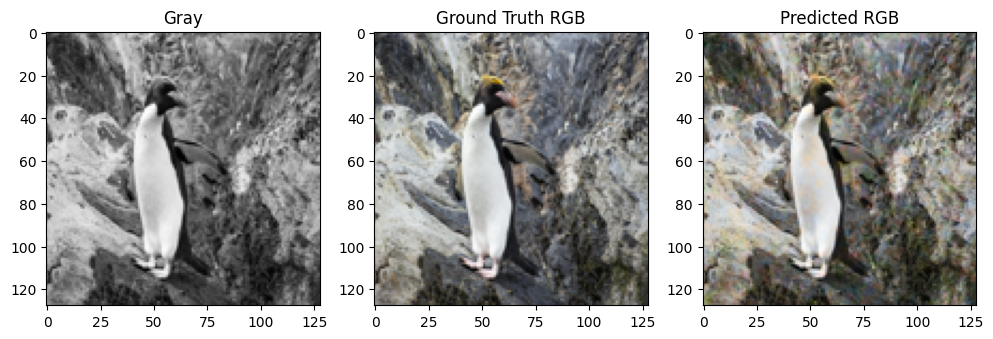

In [8]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_gray = X[0:1].transpose(0,3,1,2)
    sample_gray_t = torch.tensor(sample_gray).float().cuda()

    pred = model(sample_gray_t).cpu().numpy()[0].transpose(1,2,0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Gray")
plt.imshow(X[0].squeeze(), cmap="gray")

plt.subplot(1,3,2)
plt.title("Ground Truth RGB")
plt.imshow(Y[0])

plt.subplot(1,3,3)
plt.title("Predicted RGB")
plt.imshow(pred)

plt.show()

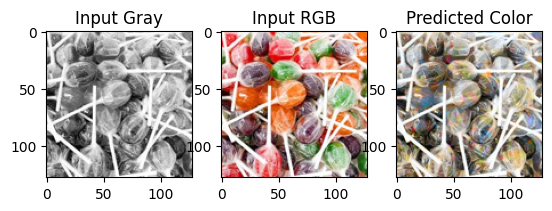

In [10]:
from PIL import Image
import numpy as np
import torch

# change this path
path = "/content/lollipops.jpg"

rgb = Image.open(path).resize((128,128))
img = Image.open(path).convert("L").resize((128,128))
g_np = np.array(img).astype(np.float32) / 255.0     # (128,128)
x_gray = torch.tensor(g_np).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,128,128)

model.eval()
with torch.no_grad():
    pred = model(x_gray)[0].cpu().numpy().transpose(1,2,0)

plt.subplot(1,3,1)
plt.title("Input Gray")
plt.imshow(g_np, cmap="gray")

plt.subplot(1,3,2)
plt.title("Input RGB")
plt.imshow(rgb)

plt.subplot(1,3,3)
plt.title("Predicted Color")
plt.imshow(pred)
plt.show()